In [55]:
import pandas as pd

In [56]:
data = pd.read_csv('C:/Users/savolk25/Downloads/Telegram Desktop/intern_task.csv')
data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [57]:
data.shape

(235258, 146)

In [58]:
data.isnull().sum().sum() # => нет нулевых значений

0

In [61]:
data.dtypes[data.dtypes != 'float64']

rank           int64
query_id       int64
feature_64     int64
feature_65     int64
feature_72     int64
feature_100    int64
dtype: object

In [62]:
data.query_id.unique()

array([   10,    25,    40, ..., 29965, 29980, 29995], dtype=int64)

In [63]:
data['rank'].unique()

array([0, 1, 2, 4, 3], dtype=int64)

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
import lightgbm as lgb
from sklearn.metrics import ndcg_score

# решение 1


In [66]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
data['rank'].unique().shape[0]

5

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
feature_names = list(set(data.columns)-set(['rank', 'query_id']))
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(feature_names, axis=1), data['rank'])

print("Размеры Train/Test: ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
groups = X_train.groupby('query_id').size().values
train_dataset = lgb.Dataset(X_train, Y_train, feature_name=feature_names, group=groups)
test_dataset = lgb.Dataset(X_test, Y_test, feature_name=feature_names, group=X_test.groupby('query_id').size().values)

len(feature_names)

Размеры Train/Test:  (176443, 2) (58815, 2) (176443,) (58815,)


144

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)

data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)
qids_train = data_train.groupby("query_id")["query_id"].count().to_numpy()
X_train = data_train.drop(["query_id", "rank"], axis=1)
y_train = data_train["rank"]

qids_validation = data_test.groupby("query_id")["query_id"].count().to_numpy()
X_validation = data_test.drop(["query_id", "rank"], axis=1)
y_validation = data_test["rank"]

In [ ]:
import lightgbm
model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
)

model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_validation, y_validation)],
    eval_group=[qids_validation],
    eval_at=10,
    verbose=10,
)

[10]	valid_0's ndcg@10: 0.559947
[20]	valid_0's ndcg@10: 0.574128
[30]	valid_0's ndcg@10: 0.586906
[40]	valid_0's ndcg@10: 0.595524
[50]	valid_0's ndcg@10: 0.601536
[60]	valid_0's ndcg@10: 0.604677
[70]	valid_0's ndcg@10: 0.60703
[80]	valid_0's ndcg@10: 0.609676
[90]	valid_0's ndcg@10: 0.61125
[100]	valid_0's ndcg@10: 0.61251


LGBMRanker(metric='ndcg', objective='lambdarank')

In [ ]:
import numpy as np

y_pred = model.predict(X_validation)

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

ndcg_scores = []
for i in range(len(qids_validation)):
    start = sum(qids_validation[:i])
    end = start + qids_validation[i]
    group_preds = y_pred[start:end]
    group_true = y_validation.iloc[start:end]
    ndcg_scores.append(ndcg_at_k(group_true, 5))

average_ndcg_5 = np.mean(ndcg_scores)
print(f"Average NDCG@5: {average_ndcg_5}")


Average NDCG@5: 0.25508445627044307


# Решение 2

In [69]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

In [77]:
features = list(set(data.columns) - set(['rank', 'query_id']))
query_col = 'query_id'
target_col = 'rank'

In [78]:
train = train.sort_values('query_id').reset_index(drop=True)
test = test.sort_values('query_id').reset_index(drop=True)

In [79]:
train_query = train[query_col].value_counts().sort_index()
test_query = test[query_col].value_counts().sort_index()

In [80]:
import optuna

In [91]:
def objective(trial):
    # search param
    param = {
        'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1), 
        #'subsample': trial.suggest_uniform('subsample', 1e-8, 1), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), 
    }
    model = lightgbm.LGBMRanker(n_estimators=1000, **param, random_state=42,)
    model.fit(
        train[features],
        train[target_col],
        group=train_query,
        eval_set=[(test[features], test[target_col])],
        eval_group=[list(test_query)],
        eval_at=[1, 3, 5, 10, 20], # ndcg@1,3,5,10,20
        early_stopping_rounds=50,
        verbose=10
    )
    scores = []
    for name, score in model.best_score_['valid_0'].items():
        scores.append(score)
    return np.mean(scores)
 
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=42)
                           )
study.optimize(objective, n_trials=50)

[I 2024-04-29 23:21:09,401] A new study created in memory with name: no-name-b58c4d65-c554-4edb-863c-86fbaa813bce
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.473162	valid_0's ndcg@3: 0.488408	valid_0's ndcg@5: 0.505774	valid_0's ndcg@10: 0.547863	valid_0's ndcg@20: 0.618362
[20]	valid_0's ndcg@1: 0.486627	valid_0's ndcg@3: 0.5055	valid_0's ndcg@5: 0.518108	valid_0's ndcg@10: 0.560423	valid_0's ndcg@20: 0.628358
[30]	valid_0's ndcg@1: 0.485518	valid_0's ndcg@3: 0.509006	valid_0's ndcg@5: 0.523757	valid_0's ndcg@10: 0.565037	valid_0's ndcg@20: 0.632432
[40]	valid_0's ndcg@1: 0.499513	valid_0's ndcg@3: 0.515961	valid_0's ndcg@5: 0.530979	valid_0's ndcg@10: 0.571257	valid_0's ndcg@20: 0.638695
[50]	valid_0's ndcg@1: 0.502025	valid_0's ndcg@3: 0.518965	valid_0's ndcg@5: 0.536084	valid_0's ndcg@10: 0.57457	valid_0's ndcg@20: 0.641458
[60]	valid_0's ndcg@1: 0.506902	valid_0's ndcg@3: 0.521558	valid_0's ndcg@5: 0.538654	valid_0's ndcg@10: 0.578747	valid_0's ndcg@20: 0.643461
[70]	valid_0's ndcg@1: 0.509266	valid_0's ndcg@3: 0.525173	valid_0's ndcg@5: 0.54249	valid

[I 2024-04-29 23:21:16,202] Trial 0 finished with value: 0.5744781768043928 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'max_depth': 7, 'num_leaves': 154, 'colsample_bytree': 0.24041677639819287, 'min_child_samples': 19}. Best is trial 0 with value: 0.5744781768043928.


[280]	valid_0's ndcg@1: 0.525137	valid_0's ndcg@3: 0.538897	valid_0's ndcg@5: 0.55683	valid_0's ndcg@10: 0.593999	valid_0's ndcg@20: 0.658124
Early stopping, best iteration is:
[235]	valid_0's ndcg@1: 0.52807	valid_0's ndcg@3: 0.538056	valid_0's ndcg@5: 0.555321	valid_0's ndcg@10: 0.593249	valid_0's ndcg@20: 0.657695


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.44398	valid_0's ndcg@3: 0.460777	valid_0's ndcg@5: 0.483653	valid_0's ndcg@10: 0.532047	valid_0's ndcg@20: 0.605778
[20]	valid_0's ndcg@1: 0.454917	valid_0's ndcg@3: 0.475853	valid_0's ndcg@5: 0.493902	valid_0's ndcg@10: 0.539597	valid_0's ndcg@20: 0.612467
[30]	valid_0's ndcg@1: 0.474729	valid_0's ndcg@3: 0.491256	valid_0's ndcg@5: 0.50865	valid_0's ndcg@10: 0.552069	valid_0's ndcg@20: 0.622697
[40]	valid_0's ndcg@1: 0.486841	valid_0's ndcg@3: 0.500208	valid_0's ndcg@5: 0.517225	valid_0's ndcg@10: 0.560176	valid_0's ndcg@20: 0.627808
[50]	valid_0's ndcg@1: 0.493218	valid_0's ndcg@3: 0.509174	valid_0's ndcg@5: 0.52504	valid_0's ndcg@10: 0.566919	valid_0's ndcg@20: 0.632504
[60]	valid_0's ndcg@1: 0.498257	valid_0's ndcg@3: 0.512476	valid_0's ndcg@5: 0.527502	valid_0's ndcg@10: 0.569585	valid_0's ndcg@20: 0.636072
[70]	valid_0's ndcg@1: 0.500602	valid_0's ndcg@3: 0.516671	valid_0's ndcg@5: 0.531544	vali

[I 2024-04-29 23:21:21,670] Trial 1 finished with value: 0.5692236627529382 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893, 'max_depth': 6, 'num_leaves': 182, 'colsample_bytree': 0.1185260448662222, 'min_child_samples': 98}. Best is trial 0 with value: 0.5744781768043928.


[280]	valid_0's ndcg@1: 0.523265	valid_0's ndcg@3: 0.532677	valid_0's ndcg@5: 0.548802	valid_0's ndcg@10: 0.589635	valid_0's ndcg@20: 0.652789
Early stopping, best iteration is:
[238]	valid_0's ndcg@1: 0.5207	valid_0's ndcg@3: 0.535427	valid_0's ndcg@5: 0.548492	valid_0's ndcg@10: 0.589265	valid_0's ndcg@20: 0.652234


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.458643	valid_0's ndcg@3: 0.474128	valid_0's ndcg@5: 0.49494	valid_0's ndcg@10: 0.538201	valid_0's ndcg@20: 0.607266
[20]	valid_0's ndcg@1: 0.467288	valid_0's ndcg@3: 0.486861	valid_0's ndcg@5: 0.503886	valid_0's ndcg@10: 0.546431	valid_0's ndcg@20: 0.615435
[30]	valid_0's ndcg@1: 0.477595	valid_0's ndcg@3: 0.495928	valid_0's ndcg@5: 0.512757	valid_0's ndcg@10: 0.553561	valid_0's ndcg@20: 0.621995
[40]	valid_0's ndcg@1: 0.490801	valid_0's ndcg@3: 0.503383	valid_0's ndcg@5: 0.520714	valid_0's ndcg@10: 0.561954	valid_0's ndcg@20: 0.628262
[50]	valid_0's ndcg@1: 0.49179	valid_0's ndcg@3: 0.509192	valid_0's ndcg@5: 0.523081	valid_0's ndcg@10: 0.564107	valid_0's ndcg@20: 0.631492
[60]	valid_0's ndcg@1: 0.497048	valid_0's ndcg@3: 0.512724	valid_0's ndcg@5: 0.527226	valid_0's ndcg@10: 0.56811	valid_0's ndcg@20: 0.634567
[70]	valid_0's ndcg@1: 0.502713	valid_0's ndcg@3: 0.514612	valid_0's ndcg@5: 0.530386	vali

[I 2024-04-29 23:21:27,671] Trial 2 finished with value: 0.5650483485595711 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07, 'max_depth': 4, 'num_leaves': 48, 'colsample_bytree': 0.373818018663584, 'min_child_samples': 55}. Best is trial 0 with value: 0.5744781768043928.


[320]	valid_0's ndcg@1: 0.519606	valid_0's ndcg@3: 0.528345	valid_0's ndcg@5: 0.54317	valid_0's ndcg@10: 0.582876	valid_0's ndcg@20: 0.647308
Early stopping, best iteration is:
[278]	valid_0's ndcg@1: 0.523084	valid_0's ndcg@3: 0.528271	valid_0's ndcg@5: 0.543839	valid_0's ndcg@10: 0.58261	valid_0's ndcg@20: 0.647438


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.473831	valid_0's ndcg@3: 0.486973	valid_0's ndcg@5: 0.502796	valid_0's ndcg@10: 0.546156	valid_0's ndcg@20: 0.616886
[20]	valid_0's ndcg@1: 0.489392	valid_0's ndcg@3: 0.503306	valid_0's ndcg@5: 0.518835	valid_0's ndcg@10: 0.560639	valid_0's ndcg@20: 0.629082
[30]	valid_0's ndcg@1: 0.49616	valid_0's ndcg@3: 0.508806	valid_0's ndcg@5: 0.524809	valid_0's ndcg@10: 0.566152	valid_0's ndcg@20: 0.632807
[40]	valid_0's ndcg@1: 0.502679	valid_0's ndcg@3: 0.512991	valid_0's ndcg@5: 0.528184	valid_0's ndcg@10: 0.570893	valid_0's ndcg@20: 0.636483
[50]	valid_0's ndcg@1: 0.510293	valid_0's ndcg@3: 0.518322	valid_0's ndcg@5: 0.535503	valid_0's ndcg@10: 0.574949	valid_0's ndcg@20: 0.640631
[60]	valid_0's ndcg@1: 0.514515	valid_0's ndcg@3: 0.523695	valid_0's ndcg@5: 0.539436	valid_0's ndcg@10: 0.578502	valid_0's ndcg@20: 0.643943
[70]	valid_0's ndcg@1: 0.518312	valid_0's ndcg@3: 0.524708	valid_0's ndcg@5: 0.539807	va

[I 2024-04-29 23:21:31,475] Trial 3 finished with value: 0.5643440457607923 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06, 'max_depth': 6, 'num_leaves': 37, 'colsample_bytree': 0.3629301836816964, 'min_child_samples': 40}. Best is trial 0 with value: 0.5744781768043928.


Early stopping, best iteration is:
[87]	valid_0's ndcg@1: 0.521569	valid_0's ndcg@3: 0.527139	valid_0's ndcg@5: 0.543395	valid_0's ndcg@10: 0.581946	valid_0's ndcg@20: 0.647671


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.460367	valid_0's ndcg@3: 0.47391	valid_0's ndcg@5: 0.492797	valid_0's ndcg@10: 0.536906	valid_0's ndcg@20: 0.607137
[20]	valid_0's ndcg@1: 0.475168	valid_0's ndcg@3: 0.488413	valid_0's ndcg@5: 0.506799	valid_0's ndcg@10: 0.5491	valid_0's ndcg@20: 0.618102
[30]	valid_0's ndcg@1: 0.48261	valid_0's ndcg@3: 0.49771	valid_0's ndcg@5: 0.513818	valid_0's ndcg@10: 0.556033	valid_0's ndcg@20: 0.624893
[40]	valid_0's ndcg@1: 0.492134	valid_0's ndcg@3: 0.502939	valid_0's ndcg@5: 0.51987	valid_0's ndcg@10: 0.562222	valid_0's ndcg@20: 0.629504
[50]	valid_0's ndcg@1: 0.497278	valid_0's ndcg@3: 0.508703	valid_0's ndcg@5: 0.524006	valid_0's ndcg@10: 0.564641	valid_0's ndcg@20: 0.631854
[60]	valid_0's ndcg@1: 0.504136	valid_0's ndcg@3: 0.513843	valid_0's ndcg@5: 0.528621	valid_0's ndcg@10: 0.569709	valid_0's ndcg@20: 0.635749
[70]	valid_0's ndcg@1: 0.508698	valid_0's ndcg@3: 0.51407	valid_0's ndcg@5: 0.532691	valid_0'

[I 2024-04-29 23:21:35,990] Trial 4 finished with value: 0.5610399248133902 and parameters: {'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'max_depth': 4, 'num_leaves': 133, 'colsample_bytree': 0.6331731119758383, 'min_child_samples': 9}. Best is trial 0 with value: 0.5744781768043928.


[200]	valid_0's ndcg@1: 0.518231	valid_0's ndcg@3: 0.52358	valid_0's ndcg@5: 0.539869	valid_0's ndcg@10: 0.579756	valid_0's ndcg@20: 0.645013
Early stopping, best iteration is:
[157]	valid_0's ndcg@1: 0.518078	valid_0's ndcg@3: 0.524419	valid_0's ndcg@5: 0.539879	valid_0's ndcg@10: 0.578777	valid_0's ndcg@20: 0.644047


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.455486	valid_0's ndcg@3: 0.463729	valid_0's ndcg@5: 0.480383	valid_0's ndcg@10: 0.524031	valid_0's ndcg@20: 0.597753
[20]	valid_0's ndcg@1: 0.465339	valid_0's ndcg@3: 0.478339	valid_0's ndcg@5: 0.496738	valid_0's ndcg@10: 0.54039	valid_0's ndcg@20: 0.610955
[30]	valid_0's ndcg@1: 0.476539	valid_0's ndcg@3: 0.487446	valid_0's ndcg@5: 0.50572	valid_0's ndcg@10: 0.548625	valid_0's ndcg@20: 0.618816
[40]	valid_0's ndcg@1: 0.476873	valid_0's ndcg@3: 0.490372	valid_0's ndcg@5: 0.510255	valid_0's ndcg@10: 0.552378	valid_0's ndcg@20: 0.622478
[50]	valid_0's ndcg@1: 0.480097	valid_0's ndcg@3: 0.495295	valid_0's ndcg@5: 0.515124	valid_0's ndcg@10: 0.55681	valid_0's ndcg@20: 0.626346
[60]	valid_0's ndcg@1: 0.487749	valid_0's ndcg@3: 0.500402	valid_0's ndcg@5: 0.520039	valid_0's ndcg@10: 0.55993	valid_0's ndcg@20: 0.629586
[70]	valid_0's ndcg@1: 0.491603	valid_0's ndcg@3: 0.505236	valid_0's ndcg@5: 0.521903	valid

[I 2024-04-29 23:21:43,273] Trial 5 finished with value: 0.5585850105195174 and parameters: {'lambda_l1': 0.0029369981104377003, 'lambda_l2': 3.425445902633376e-07, 'max_depth': 3, 'num_leaves': 243, 'colsample_bytree': 0.9690688297671034, 'min_child_samples': 82}. Best is trial 0 with value: 0.5744781768043928.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Us

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.46253	valid_0's ndcg@3: 0.480202	valid_0's ndcg@5: 0.499106	valid_0's ndcg@10: 0.544538	valid_0's ndcg@20: 0.614818
[20]	valid_0's ndcg@1: 0.474318	valid_0's ndcg@3: 0.491894	valid_0's ndcg@5: 0.512265	valid_0's ndcg@10: 0.557044	valid_0's ndcg@20: 0.624915
[30]	valid_0's ndcg@1: 0.486612	valid_0's ndcg@3: 0.506485	valid_0's ndcg@5: 0.520906	valid_0's ndcg@10: 0.564616	valid_0's ndcg@20: 0.631198
[40]	valid_0's ndcg@1: 0.494512	valid_0's ndcg@3: 0.513189	valid_0's ndcg@5: 0.527955	valid_0's ndcg@10: 0.569837	valid_0's ndcg@20: 0.637144
[50]	valid_0's ndcg@1: 0.501533	valid_0's ndcg@3: 0.513511	valid_0's ndcg@5: 0.530853	valid_0's ndcg@10: 0.572387	valid_0's ndcg@20: 0.639519
[60]	valid_0's ndcg@1: 0.512318	valid_0's ndcg@3: 0.519147	valid_0's ndcg@5: 0.536376	valid_0's ndcg@10: 0.577699	valid_0's ndcg@20: 0.643439
[70]	valid_0's ndcg@1: 0.513679	valid_0's ndcg@3: 0.523097	valid_0's ndcg@5: 0.540064	va

[I 2024-04-29 23:21:49,515] Trial 6 finished with value: 0.5745330918339022 and parameters: {'lambda_l1': 5.514725787121931e-06, 'lambda_l2': 7.569183361880229e-08, 'max_depth': 7, 'num_leaves': 114, 'colsample_bytree': 0.20983441136030095, 'min_child_samples': 52}. Best is trial 6 with value: 0.5745330918339022.


[280]	valid_0's ndcg@1: 0.522959	valid_0's ndcg@3: 0.539574	valid_0's ndcg@5: 0.555231	valid_0's ndcg@10: 0.594011	valid_0's ndcg@20: 0.657628
Early stopping, best iteration is:
[233]	valid_0's ndcg@1: 0.528094	valid_0's ndcg@3: 0.53907	valid_0's ndcg@5: 0.555077	valid_0's ndcg@10: 0.592627	valid_0's ndcg@20: 0.657798


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.466366	valid_0's ndcg@3: 0.478214	valid_0's ndcg@5: 0.496053	valid_0's ndcg@10: 0.537591	valid_0's ndcg@20: 0.60762
[20]	valid_0's ndcg@1: 0.477547	valid_0's ndcg@3: 0.492069	valid_0's ndcg@5: 0.508067	valid_0's ndcg@10: 0.547679	valid_0's ndcg@20: 0.619065
[30]	valid_0's ndcg@1: 0.478961	valid_0's ndcg@3: 0.497714	valid_0's ndcg@5: 0.514083	valid_0's ndcg@10: 0.554758	valid_0's ndcg@20: 0.623403
[40]	valid_0's ndcg@1: 0.491331	valid_0's ndcg@3: 0.505468	valid_0's ndcg@5: 0.521057	valid_0's ndcg@10: 0.56084	valid_0's ndcg@20: 0.629169
[50]	valid_0's ndcg@1: 0.494565	valid_0's ndcg@3: 0.507254	valid_0's ndcg@5: 0.52388	valid_0's ndcg@10: 0.563917	valid_0's ndcg@20: 0.631188
[60]	valid_0's ndcg@1: 0.502517	valid_0's ndcg@3: 0.512078	valid_0's ndcg@5: 0.525906	valid_0's ndcg@10: 0.568336	valid_0's ndcg@20: 0.634559
[70]	valid_0's ndcg@1: 0.508272	valid_0's ndcg@3: 0.515239	valid_0's ndcg@5: 0.529803	vali

[I 2024-04-29 23:21:53,837] Trial 7 finished with value: 0.5602085548079871 and parameters: {'lambda_l1': 2.039373116525212e-08, 'lambda_l2': 1.527156759251193, 'max_depth': 4, 'num_leaves': 170, 'colsample_bytree': 0.3805399684804699, 'min_child_samples': 54}. Best is trial 6 with value: 0.5745330918339022.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.484812	valid_0's ndcg@3: 0.494141	valid_0's ndcg@5: 0.50908	valid_0's ndcg@10: 0.552934	valid_0's ndcg@20: 0.621472
[20]	valid_0's ndcg@1: 0.491169	valid_0's ndcg@3: 0.501495	valid_0's ndcg@5: 0.521246	valid_0's ndcg@10: 0.563511	valid_0's ndcg@20: 0.630344
[30]	valid_0's ndcg@1: 0.501619	valid_0's ndcg@3: 0.515201	valid_0's ndcg@5: 0.535024	valid_0's ndcg@10: 0.572082	valid_0's ndcg@20: 0.640088
[40]	valid_0's ndcg@1: 0.513607	valid_0's ndcg@3: 0.521662	valid_0's ndcg@5: 0.539997	valid_0's ndcg@10: 0.580128	valid_0's ndcg@20: 0.645752
[50]	valid_0's ndcg@1: 0.519329	valid_0's ndcg@3: 0.524292	valid_0's ndcg@5: 0.544505	valid_0's ndcg@10: 0.583523	valid_0's ndcg@20: 0.648674
[60]	valid_0's ndcg@1: 0.512953	valid_0's ndcg@3: 0.527656	valid_0's ndcg@5: 0.546079	valid_0's ndcg@10: 0.584676	valid_0's ndcg@20: 0.650118
[70]	valid_0's ndcg@1: 0.515193	valid_0's ndcg@3: 0.528163	valid_0's ndcg@5: 0.546485	va

[I 2024-04-29 23:21:59,324] Trial 8 finished with value: 0.5646604698259073 and parameters: {'lambda_l1': 0.0008325158565947976, 'lambda_l2': 4.609885087947832e-07, 'max_depth': 8, 'num_leaves': 199, 'colsample_bytree': 0.9455490474077702, 'min_child_samples': 90}. Best is trial 6 with value: 0.5745330918339022.


[100]	valid_0's ndcg@1: 0.519735	valid_0's ndcg@3: 0.532955	valid_0's ndcg@5: 0.550433	valid_0's ndcg@10: 0.58924	valid_0's ndcg@20: 0.655003
Early stopping, best iteration is:
[51]	valid_0's ndcg@1: 0.520891	valid_0's ndcg@3: 0.524937	valid_0's ndcg@5: 0.54481	valid_0's ndcg@10: 0.583833	valid_0's ndcg@20: 0.648831


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.417008	valid_0's ndcg@3: 0.436942	valid_0's ndcg@5: 0.457679	valid_0's ndcg@10: 0.509315	valid_0's ndcg@20: 0.58505
[20]	valid_0's ndcg@1: 0.446669	valid_0's ndcg@3: 0.464334	valid_0's ndcg@5: 0.481721	valid_0's ndcg@10: 0.528879	valid_0's ndcg@20: 0.600831
[30]	valid_0's ndcg@1: 0.462029	valid_0's ndcg@3: 0.469706	valid_0's ndcg@5: 0.48764	valid_0's ndcg@10: 0.533148	valid_0's ndcg@20: 0.606291
[40]	valid_0's ndcg@1: 0.469341	valid_0's ndcg@3: 0.476425	valid_0's ndcg@5: 0.494483	valid_0's ndcg@10: 0.538913	valid_0's ndcg@20: 0.611158
[50]	valid_0's ndcg@1: 0.472866	valid_0's ndcg@3: 0.482434	valid_0's ndcg@5: 0.499801	valid_0's ndcg@10: 0.543301	valid_0's ndcg@20: 0.614991
[60]	valid_0's ndcg@1: 0.484721	valid_0's ndcg@3: 0.493015	valid_0's ndcg@5: 0.507859	valid_0's ndcg@10: 0.548606	valid_0's ndcg@20: 0.619707
[70]	valid_0's ndcg@1: 0.486708	valid_0's ndcg@3: 0.497901	valid_0's ndcg@5: 0.51196	vali

[I 2024-04-29 23:22:04,164] Trial 9 finished with value: 0.5482840494455463 and parameters: {'lambda_l1': 0.002404915432737351, 'lambda_l2': 1.9809253750493907, 'max_depth': 3, 'num_leaves': 51, 'colsample_bytree': 0.14070456001948428, 'min_child_samples': 36}. Best is trial 6 with value: 0.5745330918339022.


[200]	valid_0's ndcg@1: 0.498281	valid_0's ndcg@3: 0.51186	valid_0's ndcg@5: 0.529401	valid_0's ndcg@10: 0.56673	valid_0's ndcg@20: 0.635714
Early stopping, best iteration is:
[154]	valid_0's ndcg@1: 0.501337	valid_0's ndcg@3: 0.511967	valid_0's ndcg@5: 0.528752	valid_0's ndcg@10: 0.565128	valid_0's ndcg@20: 0.634236


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.484358	valid_0's ndcg@3: 0.496538	valid_0's ndcg@5: 0.515175	valid_0's ndcg@10: 0.556733	valid_0's ndcg@20: 0.625145
[20]	valid_0's ndcg@1: 0.489731	valid_0's ndcg@3: 0.506763	valid_0's ndcg@5: 0.524956	valid_0's ndcg@10: 0.564648	valid_0's ndcg@20: 0.633226
[30]	valid_0's ndcg@1: 0.510087	valid_0's ndcg@3: 0.519945	valid_0's ndcg@5: 0.536241	valid_0's ndcg@10: 0.574853	valid_0's ndcg@20: 0.642242
[40]	valid_0's ndcg@1: 0.51057	valid_0's ndcg@3: 0.522565	valid_0's ndcg@5: 0.539379	valid_0's ndcg@10: 0.579923	valid_0's ndcg@20: 0.645275
[50]	valid_0's ndcg@1: 0.522329	valid_0's ndcg@3: 0.528345	valid_0's ndcg@5: 0.544473	valid_0's ndcg@10: 0.585227	valid_0's ndcg@20: 0.650118
[60]	valid_0's ndcg@1: 0.524058	valid_0's ndcg@3: 0.531777	valid_0's ndcg@5: 0.5476	valid_0's ndcg@10: 0.587068	valid_0's ndcg@20: 0.652274
[70]	valid_0's ndcg@1: 0.52466	valid_0's ndcg@3: 0.532788	valid_0's ndcg@5: 0.550145	valid

[I 2024-04-29 23:22:10,752] Trial 10 finished with value: 0.5736360484268883 and parameters: {'lambda_l1': 1.6341730790777765e-06, 'lambda_l2': 1.1323342574942026e-08, 'max_depth': 8, 'num_leaves': 90, 'colsample_bytree': 0.639929107656765, 'min_child_samples': 71}. Best is trial 6 with value: 0.5745330918339022.


[160]	valid_0's ndcg@1: 0.524158	valid_0's ndcg@3: 0.536731	valid_0's ndcg@5: 0.557971	valid_0's ndcg@10: 0.595387	valid_0's ndcg@20: 0.659245
Early stopping, best iteration is:
[113]	valid_0's ndcg@1: 0.529097	valid_0's ndcg@3: 0.534889	valid_0's ndcg@5: 0.554563	valid_0's ndcg@10: 0.593247	valid_0's ndcg@20: 0.656384


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.4652	valid_0's ndcg@3: 0.486362	valid_0's ndcg@5: 0.504807	valid_0's ndcg@10: 0.545647	valid_0's ndcg@20: 0.617534
[20]	valid_0's ndcg@1: 0.485155	valid_0's ndcg@3: 0.501089	valid_0's ndcg@5: 0.519809	valid_0's ndcg@10: 0.559041	valid_0's ndcg@20: 0.628866
[30]	valid_0's ndcg@1: 0.490108	valid_0's ndcg@3: 0.507967	valid_0's ndcg@5: 0.524681	valid_0's ndcg@10: 0.565454	valid_0's ndcg@20: 0.633286
[40]	valid_0's ndcg@1: 0.500583	valid_0's ndcg@3: 0.516595	valid_0's ndcg@5: 0.532594	valid_0's ndcg@10: 0.573073	valid_0's ndcg@20: 0.639152
[50]	valid_0's ndcg@1: 0.506009	valid_0's ndcg@3: 0.520652	valid_0's ndcg@5: 0.536911	valid_0's ndcg@10: 0.576498	valid_0's ndcg@20: 0.64235
[60]	valid_0's ndcg@1: 0.509309	valid_0's ndcg@3: 0.52465	valid_0's ndcg@5: 0.541782	valid_0's ndcg@10: 0.579794	valid_0's ndcg@20: 0.645695
[70]	valid_0's ndcg@1: 0.514496	valid_0's ndcg@3: 0.531923	valid_0's ndcg@5: 0.544982	valid

[I 2024-04-29 23:22:15,574] Trial 11 finished with value: 0.5660294674449109 and parameters: {'lambda_l1': 2.2864000799553145e-06, 'lambda_l2': 0.0028773153947654583, 'max_depth': 7, 'num_leaves': 120, 'colsample_bytree': 0.25325640070800803, 'min_child_samples': 5}. Best is trial 6 with value: 0.5745330918339022.


Early stopping, best iteration is:
[74]	valid_0's ndcg@1: 0.517863	valid_0's ndcg@3: 0.532459	valid_0's ndcg@5: 0.546375	valid_0's ndcg@10: 0.584245	valid_0's ndcg@20: 0.649205


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.484019	valid_0's ndcg@3: 0.499422	valid_0's ndcg@5: 0.517308	valid_0's ndcg@10: 0.557655	valid_0's ndcg@20: 0.626198
[20]	valid_0's ndcg@1: 0.494144	valid_0's ndcg@3: 0.510049	valid_0's ndcg@5: 0.530553	valid_0's ndcg@10: 0.567793	valid_0's ndcg@20: 0.633392
[30]	valid_0's ndcg@1: 0.495826	valid_0's ndcg@3: 0.513693	valid_0's ndcg@5: 0.533673	valid_0's ndcg@10: 0.572457	valid_0's ndcg@20: 0.637089
[40]	valid_0's ndcg@1: 0.506047	valid_0's ndcg@3: 0.51856	valid_0's ndcg@5: 0.538895	valid_0's ndcg@10: 0.577251	valid_0's ndcg@20: 0.642201
[50]	valid_0's ndcg@1: 0.512423	valid_0's ndcg@3: 0.525654	valid_0's ndcg@5: 0.545037	valid_0's ndcg@10: 0.582299	valid_0's ndcg@20: 0.6462
[60]	valid_0's ndcg@1: 0.519019	valid_0's ndcg@3: 0.531302	valid_0's ndcg@5: 0.548948	valid_0's ndcg@10: 0.585841	valid_0's ndcg@20: 0.650504
[70]	valid_0's ndcg@1: 0.521531	valid_0's ndcg@3: 0.532817	valid_0's ndcg@5: 0.550623	vali

[I 2024-04-29 23:22:22,973] Trial 12 finished with value: 0.5768434056823094 and parameters: {'lambda_l1': 3.738425892816665e-06, 'lambda_l2': 0.0001981671721667573, 'max_depth': 7, 'num_leaves': 121, 'colsample_bytree': 0.49810988918502913, 'min_child_samples': 25}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[205]	valid_0's ndcg@1: 0.529818	valid_0's ndcg@3: 0.541958	valid_0's ndcg@5: 0.557972	valid_0's ndcg@10: 0.596277	valid_0's ndcg@20: 0.658192


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.491938	valid_0's ndcg@3: 0.500751	valid_0's ndcg@5: 0.517829	valid_0's ndcg@10: 0.558261	valid_0's ndcg@20: 0.626642
[20]	valid_0's ndcg@1: 0.505727	valid_0's ndcg@3: 0.509596	valid_0's ndcg@5: 0.527681	valid_0's ndcg@10: 0.566108	valid_0's ndcg@20: 0.634377
[30]	valid_0's ndcg@1: 0.506849	valid_0's ndcg@3: 0.514607	valid_0's ndcg@5: 0.533792	valid_0's ndcg@10: 0.572875	valid_0's ndcg@20: 0.63866
[40]	valid_0's ndcg@1: 0.514558	valid_0's ndcg@3: 0.521452	valid_0's ndcg@5: 0.53901	valid_0's ndcg@10: 0.578363	valid_0's ndcg@20: 0.642607
[50]	valid_0's ndcg@1: 0.518704	valid_0's ndcg@3: 0.524485	valid_0's ndcg@5: 0.542031	valid_0's ndcg@10: 0.581312	valid_0's ndcg@20: 0.64525
[60]	valid_0's ndcg@1: 0.516511	valid_0's ndcg@3: 0.527355	valid_0's ndcg@5: 0.546254	valid_0's ndcg@10: 0.584135	valid_0's ndcg@20: 0.64769
[70]	valid_0's ndcg@1: 0.517056	valid_0's ndcg@3: 0.530739	valid_0's ndcg@5: 0.548146	valid

[I 2024-04-29 23:22:27,904] Trial 13 finished with value: 0.5710938283373633 and parameters: {'lambda_l1': 7.879761022710774e-07, 'lambda_l2': 0.0001667148686572712, 'max_depth': 7, 'num_leaves': 90, 'colsample_bytree': 0.5218346969990579, 'min_child_samples': 31}. Best is trial 12 with value: 0.5768434056823094.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\U

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.469007	valid_0's ndcg@3: 0.492387	valid_0's ndcg@5: 0.508219	valid_0's ndcg@10: 0.550213	valid_0's ndcg@20: 0.619491
[20]	valid_0's ndcg@1: 0.489545	valid_0's ndcg@3: 0.501854	valid_0's ndcg@5: 0.51982	valid_0's ndcg@10: 0.559622	valid_0's ndcg@20: 0.628156
[30]	valid_0's ndcg@1: 0.50352	valid_0's ndcg@3: 0.509934	valid_0's ndcg@5: 0.528796	valid_0's ndcg@10: 0.569149	valid_0's ndcg@20: 0.636751
[40]	valid_0's ndcg@1: 0.504184	valid_0's ndcg@3: 0.517756	valid_0's ndcg@5: 0.533332	valid_0's ndcg@10: 0.57386	valid_0's ndcg@20: 0.640254
[50]	valid_0's ndcg@1: 0.51772	valid_0's ndcg@3: 0.52344	valid_0's ndcg@5: 0.540258	valid_0's ndcg@10: 0.578404	valid_0's ndcg@20: 0.644724
[60]	valid_0's ndcg@1: 0.522038	valid_0's ndcg@3: 0.527473	valid_0's ndcg@5: 0.543603	valid_0's ndcg@10: 0.581229	valid_0's ndcg@20: 0.647475
[70]	valid_0's ndcg@1: 0.52317	valid_0's ndcg@3: 0.529705	valid_0's ndcg@5: 0.544219	valid_0

[I 2024-04-29 23:22:33,376] Trial 14 finished with value: 0.5714841733695813 and parameters: {'lambda_l1': 0.08857600965028074, 'lambda_l2': 0.00018558554388166442, 'max_depth': 6, 'num_leaves': 89, 'colsample_bytree': 0.7919833106041956, 'min_child_samples': 68}. Best is trial 12 with value: 0.5768434056823094.


[160]	valid_0's ndcg@1: 0.530611	valid_0's ndcg@3: 0.535322	valid_0's ndcg@5: 0.549135	valid_0's ndcg@10: 0.589384	valid_0's ndcg@20: 0.654532
Early stopping, best iteration is:
[110]	valid_0's ndcg@1: 0.535015	valid_0's ndcg@3: 0.533809	valid_0's ndcg@5: 0.548603	valid_0's ndcg@10: 0.587302	valid_0's ndcg@20: 0.652692


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.473081	valid_0's ndcg@3: 0.48766	valid_0's ndcg@5: 0.505478	valid_0's ndcg@10: 0.549658	valid_0's ndcg@20: 0.618695
[20]	valid_0's ndcg@1: 0.479223	valid_0's ndcg@3: 0.496478	valid_0's ndcg@5: 0.516452	valid_0's ndcg@10: 0.558614	valid_0's ndcg@20: 0.626882
[30]	valid_0's ndcg@1: 0.491732	valid_0's ndcg@3: 0.505898	valid_0's ndcg@5: 0.523848	valid_0's ndcg@10: 0.564317	valid_0's ndcg@20: 0.632531
[40]	valid_0's ndcg@1: 0.495248	valid_0's ndcg@3: 0.507275	valid_0's ndcg@5: 0.526635	valid_0's ndcg@10: 0.567032	valid_0's ndcg@20: 0.635012
[50]	valid_0's ndcg@1: 0.497373	valid_0's ndcg@3: 0.512461	valid_0's ndcg@5: 0.530036	valid_0's ndcg@10: 0.57048	valid_0's ndcg@20: 0.637057
[60]	valid_0's ndcg@1: 0.501791	valid_0's ndcg@3: 0.517774	valid_0's ndcg@5: 0.533965	valid_0's ndcg@10: 0.574325	valid_0's ndcg@20: 0.639891
[70]	valid_0's ndcg@1: 0.501982	valid_0's ndcg@3: 0.51835	valid_0's ndcg@5: 0.536697	vali

[I 2024-04-29 23:22:39,606] Trial 15 finished with value: 0.564288816124306 and parameters: {'lambda_l1': 9.86874546485385, 'lambda_l2': 0.00878883786743463, 'max_depth': 8, 'num_leaves': 122, 'colsample_bytree': 0.5231306140259455, 'min_child_samples': 24}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[129]	valid_0's ndcg@1: 0.515126	valid_0's ndcg@3: 0.528797	valid_0's ndcg@5: 0.545107	valid_0's ndcg@10: 0.584136	valid_0's ndcg@20: 0.648278


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.450131	valid_0's ndcg@3: 0.465959	valid_0's ndcg@5: 0.485947	valid_0's ndcg@10: 0.531365	valid_0's ndcg@20: 0.603091
[20]	valid_0's ndcg@1: 0.462817	valid_0's ndcg@3: 0.480819	valid_0's ndcg@5: 0.499379	valid_0's ndcg@10: 0.542556	valid_0's ndcg@20: 0.611915
[30]	valid_0's ndcg@1: 0.471892	valid_0's ndcg@3: 0.488268	valid_0's ndcg@5: 0.506952	valid_0's ndcg@10: 0.54998	valid_0's ndcg@20: 0.618915
[40]	valid_0's ndcg@1: 0.472995	valid_0's ndcg@3: 0.493198	valid_0's ndcg@5: 0.510152	valid_0's ndcg@10: 0.55193	valid_0's ndcg@20: 0.621848
[50]	valid_0's ndcg@1: 0.477705	valid_0's ndcg@3: 0.494436	valid_0's ndcg@5: 0.514168	valid_0's ndcg@10: 0.555041	valid_0's ndcg@20: 0.624666
[60]	valid_0's ndcg@1: 0.481908	valid_0's ndcg@3: 0.496994	valid_0's ndcg@5: 0.516086	valid_0's ndcg@10: 0.556929	valid_0's ndcg@20: 0.626256
[70]	valid_0's ndcg@1: 0.48857	valid_0's ndcg@3: 0.50453	valid_0's ndcg@5: 0.519528	valid

[I 2024-04-29 23:22:44,402] Trial 16 finished with value: 0.549790668493808 and parameters: {'lambda_l1': 2.6162640367120767e-07, 'lambda_l2': 2.1226785527161194e-05, 'max_depth': 5, 'num_leaves': 6, 'colsample_bytree': 0.7607839089329453, 'min_child_samples': 47}. Best is trial 12 with value: 0.5768434056823094.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\U

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.47578	valid_0's ndcg@3: 0.492018	valid_0's ndcg@5: 0.511649	valid_0's ndcg@10: 0.553233	valid_0's ndcg@20: 0.621448
[20]	valid_0's ndcg@1: 0.491302	valid_0's ndcg@3: 0.508756	valid_0's ndcg@5: 0.525635	valid_0's ndcg@10: 0.564719	valid_0's ndcg@20: 0.633256
[30]	valid_0's ndcg@1: 0.502727	valid_0's ndcg@3: 0.516262	valid_0's ndcg@5: 0.532877	valid_0's ndcg@10: 0.569197	valid_0's ndcg@20: 0.638516
[40]	valid_0's ndcg@1: 0.506902	valid_0's ndcg@3: 0.52011	valid_0's ndcg@5: 0.535265	valid_0's ndcg@10: 0.573559	valid_0's ndcg@20: 0.641812
[50]	valid_0's ndcg@1: 0.506806	valid_0's ndcg@3: 0.521833	valid_0's ndcg@5: 0.537649	valid_0's ndcg@10: 0.57655	valid_0's ndcg@20: 0.644685
[60]	valid_0's ndcg@1: 0.516058	valid_0's ndcg@3: 0.525658	valid_0's ndcg@5: 0.542524	valid_0's ndcg@10: 0.580692	valid_0's ndcg@20: 0.64754
[70]	valid_0's ndcg@1: 0.515676	valid_0's ndcg@3: 0.528109	valid_0's ndcg@5: 0.543552	valid

[I 2024-04-29 23:22:49,878] Trial 17 finished with value: 0.5696362514154609 and parameters: {'lambda_l1': 1.295765463708443e-05, 'lambda_l2': 5.298027008696084e-08, 'max_depth': 7, 'num_leaves': 220, 'colsample_bytree': 0.4358227036919142, 'min_child_samples': 19}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[98]	valid_0's ndcg@1: 0.524703	valid_0's ndcg@3: 0.533505	valid_0's ndcg@5: 0.548479	valid_0's ndcg@10: 0.587921	valid_0's ndcg@20: 0.653574


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.47119	valid_0's ndcg@3: 0.484842	valid_0's ndcg@5: 0.499793	valid_0's ndcg@10: 0.544663	valid_0's ndcg@20: 0.613599
[20]	valid_0's ndcg@1: 0.489817	valid_0's ndcg@3: 0.5007	valid_0's ndcg@5: 0.514607	valid_0's ndcg@10: 0.554882	valid_0's ndcg@20: 0.624107
[30]	valid_0's ndcg@1: 0.495061	valid_0's ndcg@3: 0.506408	valid_0's ndcg@5: 0.520104	valid_0's ndcg@10: 0.560108	valid_0's ndcg@20: 0.62987
[40]	valid_0's ndcg@1: 0.507881	valid_0's ndcg@3: 0.513662	valid_0's ndcg@5: 0.529129	valid_0's ndcg@10: 0.567608	valid_0's ndcg@20: 0.635019
[50]	valid_0's ndcg@1: 0.50629	valid_0's ndcg@3: 0.517762	valid_0's ndcg@5: 0.531185	valid_0's ndcg@10: 0.569769	valid_0's ndcg@20: 0.636639
[60]	valid_0's ndcg@1: 0.509161	valid_0's ndcg@3: 0.517587	valid_0's ndcg@5: 0.533595	valid_0's ndcg@10: 0.571554	valid_0's ndcg@20: 0.638694
[70]	valid_0's ndcg@1: 0.510001	valid_0's ndcg@3: 0.520584	valid_0's ndcg@5: 0.534702	valid_

[I 2024-04-29 23:22:56,437] Trial 18 finished with value: 0.5692872332633143 and parameters: {'lambda_l1': 1.413900729470064e-07, 'lambda_l2': 1.4577898537336529e-05, 'max_depth': 5, 'num_leaves': 136, 'colsample_bytree': 0.26434276292638625, 'min_child_samples': 64}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[244]	valid_0's ndcg@1: 0.527769	valid_0's ndcg@3: 0.534072	valid_0's ndcg@5: 0.547388	valid_0's ndcg@10: 0.586605	valid_0's ndcg@20: 0.650602


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.477628	valid_0's ndcg@3: 0.488817	valid_0's ndcg@5: 0.507372	valid_0's ndcg@10: 0.552807	valid_0's ndcg@20: 0.620724
[20]	valid_0's ndcg@1: 0.495501	valid_0's ndcg@3: 0.504168	valid_0's ndcg@5: 0.522039	valid_0's ndcg@10: 0.564114	valid_0's ndcg@20: 0.630249
[30]	valid_0's ndcg@1: 0.508115	valid_0's ndcg@3: 0.513307	valid_0's ndcg@5: 0.531877	valid_0's ndcg@10: 0.572134	valid_0's ndcg@20: 0.639775
[40]	valid_0's ndcg@1: 0.519024	valid_0's ndcg@3: 0.520208	valid_0's ndcg@5: 0.539072	valid_0's ndcg@10: 0.577752	valid_0's ndcg@20: 0.644242
[50]	valid_0's ndcg@1: 0.516096	valid_0's ndcg@3: 0.522622	valid_0's ndcg@5: 0.539875	valid_0's ndcg@10: 0.580175	valid_0's ndcg@20: 0.645475
[60]	valid_0's ndcg@1: 0.523179	valid_0's ndcg@3: 0.528513	valid_0's ndcg@5: 0.544799	valid_0's ndcg@10: 0.583699	valid_0's ndcg@20: 0.648464
[70]	valid_0's ndcg@1: 0.520762	valid_0's ndcg@3: 0.528866	valid_0's ndcg@5: 0.546493	v

[I 2024-04-29 23:23:03,337] Trial 19 finished with value: 0.5744171898024679 and parameters: {'lambda_l1': 7.5657704843133595e-06, 'lambda_l2': 0.0028727479945002223, 'max_depth': 7, 'num_leaves': 75, 'colsample_bytree': 0.6663957994268338, 'min_child_samples': 29}. Best is trial 12 with value: 0.5768434056823094.


[200]	valid_0's ndcg@1: 0.527478	valid_0's ndcg@3: 0.537802	valid_0's ndcg@5: 0.556754	valid_0's ndcg@10: 0.593339	valid_0's ndcg@20: 0.65825
Early stopping, best iteration is:
[154]	valid_0's ndcg@1: 0.530897	valid_0's ndcg@3: 0.538127	valid_0's ndcg@5: 0.554532	valid_0's ndcg@10: 0.591924	valid_0's ndcg@20: 0.656606


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.479925	valid_0's ndcg@3: 0.492254	valid_0's ndcg@5: 0.512633	valid_0's ndcg@10: 0.555103	valid_0's ndcg@20: 0.622227
[20]	valid_0's ndcg@1: 0.487811	valid_0's ndcg@3: 0.508483	valid_0's ndcg@5: 0.527413	valid_0's ndcg@10: 0.568554	valid_0's ndcg@20: 0.633994
[30]	valid_0's ndcg@1: 0.502751	valid_0's ndcg@3: 0.517487	valid_0's ndcg@5: 0.536591	valid_0's ndcg@10: 0.574899	valid_0's ndcg@20: 0.64083
[40]	valid_0's ndcg@1: 0.511033	valid_0's ndcg@3: 0.525289	valid_0's ndcg@5: 0.542083	valid_0's ndcg@10: 0.581953	valid_0's ndcg@20: 0.646298
[50]	valid_0's ndcg@1: 0.518675	valid_0's ndcg@3: 0.527657	valid_0's ndcg@5: 0.54573	valid_0's ndcg@10: 0.585771	valid_0's ndcg@20: 0.649649
[60]	valid_0's ndcg@1: 0.513736	valid_0's ndcg@3: 0.52862	valid_0's ndcg@5: 0.547521	valid_0's ndcg@10: 0.587741	valid_0's ndcg@20: 0.651004
[70]	valid_0's ndcg@1: 0.514162	valid_0's ndcg@3: 0.531866	valid_0's ndcg@5: 0.549344	vali

[I 2024-04-29 23:23:08,371] Trial 20 finished with value: 0.565499389393802 and parameters: {'lambda_l1': 0.031441939307626676, 'lambda_l2': 0.03488853762413084, 'max_depth': 8, 'num_leaves': 155, 'colsample_bytree': 0.47203301658795527, 'min_child_samples': 44}. Best is trial 12 with value: 0.5768434056823094.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Use

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.469222	valid_0's ndcg@3: 0.479911	valid_0's ndcg@5: 0.501086	valid_0's ndcg@10: 0.543742	valid_0's ndcg@20: 0.615371
[20]	valid_0's ndcg@1: 0.48271	valid_0's ndcg@3: 0.500808	valid_0's ndcg@5: 0.514659	valid_0's ndcg@10: 0.557725	valid_0's ndcg@20: 0.627113
[30]	valid_0's ndcg@1: 0.490963	valid_0's ndcg@3: 0.509323	valid_0's ndcg@5: 0.522817	valid_0's ndcg@10: 0.56418	valid_0's ndcg@20: 0.632257
[40]	valid_0's ndcg@1: 0.498753	valid_0's ndcg@3: 0.513726	valid_0's ndcg@5: 0.529412	valid_0's ndcg@10: 0.569218	valid_0's ndcg@20: 0.63625
[50]	valid_0's ndcg@1: 0.508717	valid_0's ndcg@3: 0.518472	valid_0's ndcg@5: 0.533567	valid_0's ndcg@10: 0.572719	valid_0's ndcg@20: 0.640404
[60]	valid_0's ndcg@1: 0.515934	valid_0's ndcg@3: 0.523522	valid_0's ndcg@5: 0.536534	valid_0's ndcg@10: 0.576659	valid_0's ndcg@20: 0.643044
[70]	valid_0's ndcg@1: 0.516492	valid_0's ndcg@3: 0.525144	valid_0's ndcg@5: 0.538932	vali

[I 2024-04-29 23:23:14,453] Trial 21 finished with value: 0.5730852174166875 and parameters: {'lambda_l1': 1.655610640401067e-05, 'lambda_l2': 0.00046495848010663675, 'max_depth': 7, 'num_leaves': 161, 'colsample_bytree': 0.21272012377441868, 'min_child_samples': 14}. Best is trial 12 with value: 0.5768434056823094.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.465988	valid_0's ndcg@3: 0.485907	valid_0's ndcg@5: 0.502216	valid_0's ndcg@10: 0.54604	valid_0's ndcg@20: 0.616296
[20]	valid_0's ndcg@1: 0.483885	valid_0's ndcg@3: 0.500056	valid_0's ndcg@5: 0.515066	valid_0's ndcg@10: 0.557301	valid_0's ndcg@20: 0.626104
[30]	valid_0's ndcg@1: 0.494426	valid_0's ndcg@3: 0.50724	valid_0's ndcg@5: 0.523889	valid_0's ndcg@10: 0.563705	valid_0's ndcg@20: 0.632
[40]	valid_0's ndcg@1: 0.49926	valid_0's ndcg@3: 0.515377	valid_0's ndcg@5: 0.527546	valid_0's ndcg@10: 0.569561	valid_0's ndcg@20: 0.636639
[50]	valid_0's ndcg@1: 0.502551	valid_0's ndcg@3: 0.518749	valid_0's ndcg@5: 0.533002	valid_0's ndcg@10: 0.573541	valid_0's ndcg@20: 0.639855
[60]	valid_0's ndcg@1: 0.515489	valid_0's ndcg@3: 0.523425	valid_0's ndcg@5: 0.53694	valid_0's ndcg@10: 0.577715	valid_0's ndcg@20: 0.642842
[70]	valid_0's ndcg@1: 0.516712	valid_0's ndcg@3: 0.524813	valid_0's ndcg@5: 0.538162	valid_0'

[I 2024-04-29 23:23:19,813] Trial 22 finished with value: 0.5671547624449785 and parameters: {'lambda_l1': 7.064618908947222e-05, 'lambda_l2': 0.14548219904677506, 'max_depth': 6, 'num_leaves': 112, 'colsample_bytree': 0.2855578952611716, 'min_child_samples': 21}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[126]	valid_0's ndcg@1: 0.524239	valid_0's ndcg@3: 0.530909	valid_0's ndcg@5: 0.545217	valid_0's ndcg@10: 0.585552	valid_0's ndcg@20: 0.649856


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.463147	valid_0's ndcg@3: 0.482663	valid_0's ndcg@5: 0.504021	valid_0's ndcg@10: 0.545552	valid_0's ndcg@20: 0.61502
[20]	valid_0's ndcg@1: 0.489163	valid_0's ndcg@3: 0.500338	valid_0's ndcg@5: 0.518761	valid_0's ndcg@10: 0.559352	valid_0's ndcg@20: 0.628684
[30]	valid_0's ndcg@1: 0.498343	valid_0's ndcg@3: 0.508516	valid_0's ndcg@5: 0.525732	valid_0's ndcg@10: 0.565567	valid_0's ndcg@20: 0.634304
[40]	valid_0's ndcg@1: 0.495229	valid_0's ndcg@3: 0.509459	valid_0's ndcg@5: 0.52916	valid_0's ndcg@10: 0.569535	valid_0's ndcg@20: 0.637151
[50]	valid_0's ndcg@1: 0.499145	valid_0's ndcg@3: 0.514324	valid_0's ndcg@5: 0.532146	valid_0's ndcg@10: 0.572553	valid_0's ndcg@20: 0.639921
[60]	valid_0's ndcg@1: 0.512423	valid_0's ndcg@3: 0.519248	valid_0's ndcg@5: 0.535476	valid_0's ndcg@10: 0.577301	valid_0's ndcg@20: 0.644254
[70]	valid_0's ndcg@1: 0.512695	valid_0's ndcg@3: 0.524285	valid_0's ndcg@5: 0.540249	val

[I 2024-04-29 23:23:24,019] Trial 23 finished with value: 0.5672271531866508 and parameters: {'lambda_l1': 8.747790665182084e-06, 'lambda_l2': 2.4741046915518195e-05, 'max_depth': 7, 'num_leaves': 144, 'colsample_bytree': 0.20879328640817651, 'min_child_samples': 34}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[82]	valid_0's ndcg@1: 0.52347	valid_0's ndcg@3: 0.530449	valid_0's ndcg@5: 0.546018	valid_0's ndcg@10: 0.584806	valid_0's ndcg@20: 0.651391


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.470464	valid_0's ndcg@3: 0.487827	valid_0's ndcg@5: 0.506067	valid_0's ndcg@10: 0.547829	valid_0's ndcg@20: 0.61892
[20]	valid_0's ndcg@1: 0.484324	valid_0's ndcg@3: 0.506161	valid_0's ndcg@5: 0.520209	valid_0's ndcg@10: 0.560086	valid_0's ndcg@20: 0.628819
[30]	valid_0's ndcg@1: 0.496666	valid_0's ndcg@3: 0.512781	valid_0's ndcg@5: 0.526712	valid_0's ndcg@10: 0.565617	valid_0's ndcg@20: 0.634736
[40]	valid_0's ndcg@1: 0.503396	valid_0's ndcg@3: 0.51836	valid_0's ndcg@5: 0.532237	valid_0's ndcg@10: 0.573216	valid_0's ndcg@20: 0.640018
[50]	valid_0's ndcg@1: 0.504222	valid_0's ndcg@3: 0.521176	valid_0's ndcg@5: 0.535095	valid_0's ndcg@10: 0.575425	valid_0's ndcg@20: 0.641967
[60]	valid_0's ndcg@1: 0.514682	valid_0's ndcg@3: 0.525852	valid_0's ndcg@5: 0.540649	valid_0's ndcg@10: 0.578521	valid_0's ndcg@20: 0.64499
[70]	valid_0's ndcg@1: 0.51484	valid_0's ndcg@3: 0.524722	valid_0's ndcg@5: 0.541957	valid

[I 2024-04-29 23:23:29,633] Trial 24 finished with value: 0.5702758951527186 and parameters: {'lambda_l1': 0.0004546193070082777, 'lambda_l2': 5.127388423866124, 'max_depth': 6, 'num_leaves': 204, 'colsample_bytree': 0.3278091543416793, 'min_child_samples': 12}. Best is trial 12 with value: 0.5768434056823094.


[210]	valid_0's ndcg@1: 0.520352	valid_0's ndcg@3: 0.535968	valid_0's ndcg@5: 0.549351	valid_0's ndcg@10: 0.589632	valid_0's ndcg@20: 0.653113
Early stopping, best iteration is:
[161]	valid_0's ndcg@1: 0.524731	valid_0's ndcg@3: 0.534549	valid_0's ndcg@5: 0.551364	valid_0's ndcg@10: 0.587911	valid_0's ndcg@20: 0.652824


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.44494	valid_0's ndcg@3: 0.461227	valid_0's ndcg@5: 0.481682	valid_0's ndcg@10: 0.531428	valid_0's ndcg@20: 0.604226
[20]	valid_0's ndcg@1: 0.467866	valid_0's ndcg@3: 0.481477	valid_0's ndcg@5: 0.500512	valid_0's ndcg@10: 0.546844	valid_0's ndcg@20: 0.618719
[30]	valid_0's ndcg@1: 0.478645	valid_0's ndcg@3: 0.492142	valid_0's ndcg@5: 0.512125	valid_0's ndcg@10: 0.556223	valid_0's ndcg@20: 0.625986
[40]	valid_0's ndcg@1: 0.486961	valid_0's ndcg@3: 0.500396	valid_0's ndcg@5: 0.517124	valid_0's ndcg@10: 0.562083	valid_0's ndcg@20: 0.631249
[50]	valid_0's ndcg@1: 0.495549	valid_0's ndcg@3: 0.503229	valid_0's ndcg@5: 0.522381	valid_0's ndcg@10: 0.565448	valid_0's ndcg@20: 0.633881
[60]	valid_0's ndcg@1: 0.500291	valid_0's ndcg@3: 0.510587	valid_0's ndcg@5: 0.52816	valid_0's ndcg@10: 0.570981	valid_0's ndcg@20: 0.638584
[70]	valid_0's ndcg@1: 0.502426	valid_0's ndcg@3: 0.514479	valid_0's ndcg@5: 0.529033	val

[I 2024-04-29 23:23:37,844] Trial 25 finished with value: 0.5727157693649794 and parameters: {'lambda_l1': 4.361708431541469e-07, 'lambda_l2': 5.456703978555937e-08, 'max_depth': 8, 'num_leaves': 106, 'colsample_bytree': 0.11351909046311837, 'min_child_samples': 26}. Best is trial 12 with value: 0.5768434056823094.


[260]	valid_0's ndcg@1: 0.519062	valid_0's ndcg@3: 0.533835	valid_0's ndcg@5: 0.551493	valid_0's ndcg@10: 0.590714	valid_0's ndcg@20: 0.655915
Early stopping, best iteration is:
[213]	valid_0's ndcg@1: 0.529488	valid_0's ndcg@3: 0.533135	valid_0's ndcg@5: 0.552689	valid_0's ndcg@10: 0.591854	valid_0's ndcg@20: 0.656412


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.453871	valid_0's ndcg@3: 0.468544	valid_0's ndcg@5: 0.486654	valid_0's ndcg@10: 0.533178	valid_0's ndcg@20: 0.607126
[20]	valid_0's ndcg@1: 0.470187	valid_0's ndcg@3: 0.483578	valid_0's ndcg@5: 0.502258	valid_0's ndcg@10: 0.545638	valid_0's ndcg@20: 0.61772
[30]	valid_0's ndcg@1: 0.484152	valid_0's ndcg@3: 0.498657	valid_0's ndcg@5: 0.515285	valid_0's ndcg@10: 0.556734	valid_0's ndcg@20: 0.626912
[40]	valid_0's ndcg@1: 0.491756	valid_0's ndcg@3: 0.506237	valid_0's ndcg@5: 0.522656	valid_0's ndcg@10: 0.562324	valid_0's ndcg@20: 0.631989
[50]	valid_0's ndcg@1: 0.494837	valid_0's ndcg@3: 0.510866	valid_0's ndcg@5: 0.527817	valid_0's ndcg@10: 0.567524	valid_0's ndcg@20: 0.636345
[60]	valid_0's ndcg@1: 0.495749	valid_0's ndcg@3: 0.511377	valid_0's ndcg@5: 0.528669	valid_0's ndcg@10: 0.569801	valid_0's ndcg@20: 0.6377
[70]	valid_0's ndcg@1: 0.498099	valid_0's ndcg@3: 0.514522	valid_0's ndcg@5: 0.531102	vali

[I 2024-04-29 23:23:44,193] Trial 26 finished with value: 0.569253163920697 and parameters: {'lambda_l1': 5.306874019259684e-05, 'lambda_l2': 3.17424996605165e-06, 'max_depth': 7, 'num_leaves': 65, 'colsample_bytree': 0.18374653856008405, 'min_child_samples': 61}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[157]	valid_0's ndcg@1: 0.524063	valid_0's ndcg@3: 0.533111	valid_0's ndcg@5: 0.54977	valid_0's ndcg@10: 0.587377	valid_0's ndcg@20: 0.651945


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.476888	valid_0's ndcg@3: 0.487872	valid_0's ndcg@5: 0.504595	valid_0's ndcg@10: 0.545692	valid_0's ndcg@20: 0.615948
[20]	valid_0's ndcg@1: 0.483446	valid_0's ndcg@3: 0.499624	valid_0's ndcg@5: 0.517515	valid_0's ndcg@10: 0.556609	valid_0's ndcg@20: 0.626004
[30]	valid_0's ndcg@1: 0.501423	valid_0's ndcg@3: 0.508874	valid_0's ndcg@5: 0.524702	valid_0's ndcg@10: 0.564682	valid_0's ndcg@20: 0.633262
[40]	valid_0's ndcg@1: 0.505865	valid_0's ndcg@3: 0.514639	valid_0's ndcg@5: 0.529764	valid_0's ndcg@10: 0.569733	valid_0's ndcg@20: 0.636715
[50]	valid_0's ndcg@1: 0.505899	valid_0's ndcg@3: 0.516158	valid_0's ndcg@5: 0.533581	valid_0's ndcg@10: 0.57237	valid_0's ndcg@20: 0.639212
[60]	valid_0's ndcg@1: 0.511687	valid_0's ndcg@3: 0.5204	valid_0's ndcg@5: 0.536798	valid_0's ndcg@10: 0.57566	valid_0's ndcg@20: 0.641591
[70]	valid_0's ndcg@1: 0.512538	valid_0's ndcg@3: 0.52229	valid_0's ndcg@5: 0.538258	valid_

[I 2024-04-29 23:23:49,432] Trial 27 finished with value: 0.5662803302496979 and parameters: {'lambda_l1': 6.67858303570214e-08, 'lambda_l2': 0.0007883889370084101, 'max_depth': 5, 'num_leaves': 188, 'colsample_bytree': 0.4434844704380323, 'min_child_samples': 78}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[167]	valid_0's ndcg@1: 0.520939	valid_0's ndcg@3: 0.52992	valid_0's ndcg@5: 0.546764	valid_0's ndcg@10: 0.58432	valid_0's ndcg@20: 0.649459


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.485724	valid_0's ndcg@3: 0.492345	valid_0's ndcg@5: 0.511363	valid_0's ndcg@10: 0.554697	valid_0's ndcg@20: 0.62262
[20]	valid_0's ndcg@1: 0.495138	valid_0's ndcg@3: 0.505335	valid_0's ndcg@5: 0.525502	valid_0's ndcg@10: 0.565887	valid_0's ndcg@20: 0.632454
[30]	valid_0's ndcg@1: 0.501356	valid_0's ndcg@3: 0.516695	valid_0's ndcg@5: 0.534408	valid_0's ndcg@10: 0.574395	valid_0's ndcg@20: 0.639787
[40]	valid_0's ndcg@1: 0.505779	valid_0's ndcg@3: 0.520843	valid_0's ndcg@5: 0.540534	valid_0's ndcg@10: 0.579085	valid_0's ndcg@20: 0.644273
[50]	valid_0's ndcg@1: 0.509137	valid_0's ndcg@3: 0.523254	valid_0's ndcg@5: 0.542782	valid_0's ndcg@10: 0.582183	valid_0's ndcg@20: 0.646305
[60]	valid_0's ndcg@1: 0.508869	valid_0's ndcg@3: 0.524406	valid_0's ndcg@5: 0.545194	valid_0's ndcg@10: 0.583281	valid_0's ndcg@20: 0.648623
[70]	valid_0's ndcg@1: 0.511692	valid_0's ndcg@3: 0.528082	valid_0's ndcg@5: 0.547348	va

[I 2024-04-29 23:23:55,404] Trial 28 finished with value: 0.5720881701371109 and parameters: {'lambda_l1': 2.8945781198289294e-06, 'lambda_l2': 6.381933078032039e-05, 'max_depth': 7, 'num_leaves': 103, 'colsample_bytree': 0.586055500227395, 'min_child_samples': 17}. Best is trial 12 with value: 0.5768434056823094.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.463462	valid_0's ndcg@3: 0.481675	valid_0's ndcg@5: 0.501334	valid_0's ndcg@10: 0.541251	valid_0's ndcg@20: 0.615003
[20]	valid_0's ndcg@1: 0.483059	valid_0's ndcg@3: 0.492391	valid_0's ndcg@5: 0.513766	valid_0's ndcg@10: 0.551474	valid_0's ndcg@20: 0.623377
[30]	valid_0's ndcg@1: 0.494689	valid_0's ndcg@3: 0.500894	valid_0's ndcg@5: 0.519704	valid_0's ndcg@10: 0.55917	valid_0's ndcg@20: 0.628722
[40]	valid_0's ndcg@1: 0.495529	valid_0's ndcg@3: 0.50446	valid_0's ndcg@5: 0.522112	valid_0's ndcg@10: 0.562507	valid_0's ndcg@20: 0.631199
[50]	valid_0's ndcg@1: 0.50171	valid_0's ndcg@3: 0.510748	valid_0's ndcg@5: 0.52794	valid_0's ndcg@10: 0.566888	valid_0's ndcg@20: 0.634951
[60]	valid_0's ndcg@1: 0.507847	valid_0's ndcg@3: 0.515317	valid_0's ndcg@5: 0.531419	valid_0's ndcg@10: 0.571783	valid_0's ndcg@20: 0.638177
[70]	valid_0's ndcg@1: 0.505674	valid_0's ndcg@3: 0.515919	valid_0's ndcg@5: 0.533485	valid

[I 2024-04-29 23:24:00,427] Trial 29 finished with value: 0.5627637098085464 and parameters: {'lambda_l1': 2.883203479289324e-05, 'lambda_l2': 9.489175007246278, 'max_depth': 6, 'num_leaves': 175, 'colsample_bytree': 0.1521051380266683, 'min_child_samples': 49}. Best is trial 12 with value: 0.5768434056823094.


Early stopping, best iteration is:
[146]	valid_0's ndcg@1: 0.51835	valid_0's ndcg@3: 0.524404	valid_0's ndcg@5: 0.542051	valid_0's ndcg@10: 0.58248	valid_0's ndcg@20: 0.646533


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.474796	valid_0's ndcg@3: 0.490588	valid_0's ndcg@5: 0.509198	valid_0's ndcg@10: 0.552536	valid_0's ndcg@20: 0.621638
[20]	valid_0's ndcg@1: 0.496838	valid_0's ndcg@3: 0.50911	valid_0's ndcg@5: 0.525252	valid_0's ndcg@10: 0.566218	valid_0's ndcg@20: 0.634279
[30]	valid_0's ndcg@1: 0.498051	valid_0's ndcg@3: 0.516819	valid_0's ndcg@5: 0.530272	valid_0's ndcg@10: 0.572816	valid_0's ndcg@20: 0.639268
[40]	valid_0's ndcg@1: 0.505302	valid_0's ndcg@3: 0.521747	valid_0's ndcg@5: 0.538224	valid_0's ndcg@10: 0.578092	valid_0's ndcg@20: 0.642705
[50]	valid_0's ndcg@1: 0.510173	valid_0's ndcg@3: 0.524733	valid_0's ndcg@5: 0.541724	valid_0's ndcg@10: 0.582808	valid_0's ndcg@20: 0.646682
[60]	valid_0's ndcg@1: 0.51794	valid_0's ndcg@3: 0.531318	valid_0's ndcg@5: 0.545857	valid_0's ndcg@10: 0.585962	valid_0's ndcg@20: 0.650182
[70]	valid_0's ndcg@1: 0.519769	valid_0's ndcg@3: 0.533462	valid_0's ndcg@5: 0.550215	val

[I 2024-04-29 23:24:08,556] Trial 30 finished with value: 0.5805920582633874 and parameters: {'lambda_l1': 1.4615368938691652e-08, 'lambda_l2': 0.17226956684925354, 'max_depth': 8, 'num_leaves': 146, 'colsample_bytree': 0.29612958781714954, 'min_child_samples': 40}. Best is trial 30 with value: 0.5805920582633874.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.472331	valid_0's ndcg@3: 0.48399	valid_0's ndcg@5: 0.504038	valid_0's ndcg@10: 0.551029	valid_0's ndcg@20: 0.620297
[20]	valid_0's ndcg@1: 0.488513	valid_0's ndcg@3: 0.503537	valid_0's ndcg@5: 0.522155	valid_0's ndcg@10: 0.566327	valid_0's ndcg@20: 0.632085
[30]	valid_0's ndcg@1: 0.498548	valid_0's ndcg@3: 0.514922	valid_0's ndcg@5: 0.531838	valid_0's ndcg@10: 0.574246	valid_0's ndcg@20: 0.63887
[40]	valid_0's ndcg@1: 0.505053	valid_0's ndcg@3: 0.522478	valid_0's ndcg@5: 0.540306	valid_0's ndcg@10: 0.578804	valid_0's ndcg@20: 0.643957
[50]	valid_0's ndcg@1: 0.507995	valid_0's ndcg@3: 0.528359	valid_0's ndcg@5: 0.543275	valid_0's ndcg@10: 0.582033	valid_0's ndcg@20: 0.647298
[60]	valid_0's ndcg@1: 0.516125	valid_0's ndcg@3: 0.531361	valid_0's ndcg@5: 0.546604	valid_0's ndcg@10: 0.585617	valid_0's ndcg@20: 0.65025
[70]	valid_0's ndcg@1: 0.518876	valid_0's ndcg@3: 0.532786	valid_0's ndcg@5: 0.550411	vali

[I 2024-04-29 23:24:18,372] Trial 31 finished with value: 0.5786447816950648 and parameters: {'lambda_l1': 1.1678741005424093e-08, 'lambda_l2': 0.64899673401811, 'max_depth': 8, 'num_leaves': 150, 'colsample_bytree': 0.3249028219420432, 'min_child_samples': 41}. Best is trial 30 with value: 0.5805920582633874.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\User

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.479739	valid_0's ndcg@3: 0.49519	valid_0's ndcg@5: 0.513019	valid_0's ndcg@10: 0.552205	valid_0's ndcg@20: 0.623432
[20]	valid_0's ndcg@1: 0.498849	valid_0's ndcg@3: 0.509493	valid_0's ndcg@5: 0.528391	valid_0's ndcg@10: 0.569557	valid_0's ndcg@20: 0.635267
[30]	valid_0's ndcg@1: 0.510073	valid_0's ndcg@3: 0.519577	valid_0's ndcg@5: 0.537889	valid_0's ndcg@10: 0.5753	valid_0's ndcg@20: 0.641967
[40]	valid_0's ndcg@1: 0.5159	valid_0's ndcg@3: 0.526444	valid_0's ndcg@5: 0.542626	valid_0's ndcg@10: 0.582841	valid_0's ndcg@20: 0.647361
[50]	valid_0's ndcg@1: 0.525601	valid_0's ndcg@3: 0.53115	valid_0's ndcg@5: 0.546937	valid_0's ndcg@10: 0.586153	valid_0's ndcg@20: 0.650646
[60]	valid_0's ndcg@1: 0.526862	valid_0's ndcg@3: 0.533823	valid_0's ndcg@5: 0.550877	valid_0's ndcg@10: 0.58845	valid_0's ndcg@20: 0.653478
[70]	valid_0's ndcg@1: 0.532263	valid_0's ndcg@3: 0.537348	valid_0's ndcg@5: 0.554435	valid_0'

[I 2024-04-29 23:24:23,547] Trial 32 finished with value: 0.5747639903757266 and parameters: {'lambda_l1': 1.3351952498398366e-08, 'lambda_l2': 0.1600993108873809, 'max_depth': 8, 'num_leaves': 147, 'colsample_bytree': 0.335661703229493, 'min_child_samples': 41}. Best is trial 30 with value: 0.5805920582633874.


Early stopping, best iteration is:
[74]	valid_0's ndcg@1: 0.533811	valid_0's ndcg@3: 0.536761	valid_0's ndcg@5: 0.555222	valid_0's ndcg@10: 0.592336	valid_0's ndcg@20: 0.65569


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.477461	valid_0's ndcg@3: 0.494509	valid_0's ndcg@5: 0.512751	valid_0's ndcg@10: 0.556213	valid_0's ndcg@20: 0.624377
[20]	valid_0's ndcg@1: 0.486426	valid_0's ndcg@3: 0.505035	valid_0's ndcg@5: 0.526156	valid_0's ndcg@10: 0.566579	valid_0's ndcg@20: 0.634194
[30]	valid_0's ndcg@1: 0.498983	valid_0's ndcg@3: 0.515218	valid_0's ndcg@5: 0.534725	valid_0's ndcg@10: 0.573417	valid_0's ndcg@20: 0.64042
[40]	valid_0's ndcg@1: 0.507451	valid_0's ndcg@3: 0.523191	valid_0's ndcg@5: 0.540954	valid_0's ndcg@10: 0.578999	valid_0's ndcg@20: 0.645595
[50]	valid_0's ndcg@1: 0.513923	valid_0's ndcg@3: 0.526555	valid_0's ndcg@5: 0.544814	valid_0's ndcg@10: 0.58338	valid_0's ndcg@20: 0.64877
[60]	valid_0's ndcg@1: 0.517505	valid_0's ndcg@3: 0.529358	valid_0's ndcg@5: 0.546254	valid_0's ndcg@10: 0.585907	valid_0's ndcg@20: 0.651718
[70]	valid_0's ndcg@1: 0.523824	valid_0's ndcg@3: 0.533131	valid_0's ndcg@5: 0.550392	vali

[I 2024-04-29 23:24:34,851] Trial 33 finished with value: 0.5836386422975071 and parameters: {'lambda_l1': 1.7958871693517147e-08, 'lambda_l2': 0.35387677305565624, 'max_depth': 8, 'num_leaves': 149, 'colsample_bytree': 0.34882173215248496, 'min_child_samples': 41}. Best is trial 33 with value: 0.5836386422975071.


Early stopping, best iteration is:
[169]	valid_0's ndcg@1: 0.537895	valid_0's ndcg@3: 0.549811	valid_0's ndcg@5: 0.564791	valid_0's ndcg@10: 0.601792	valid_0's ndcg@20: 0.663904


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.482887	valid_0's ndcg@3: 0.49582	valid_0's ndcg@5: 0.513797	valid_0's ndcg@10: 0.553798	valid_0's ndcg@20: 0.624738
[20]	valid_0's ndcg@1: 0.503577	valid_0's ndcg@3: 0.51195	valid_0's ndcg@5: 0.527291	valid_0's ndcg@10: 0.566684	valid_0's ndcg@20: 0.635732
[30]	valid_0's ndcg@1: 0.501925	valid_0's ndcg@3: 0.51427	valid_0's ndcg@5: 0.532333	valid_0's ndcg@10: 0.573599	valid_0's ndcg@20: 0.639057
[40]	valid_0's ndcg@1: 0.506171	valid_0's ndcg@3: 0.520448	valid_0's ndcg@5: 0.537547	valid_0's ndcg@10: 0.579097	valid_0's ndcg@20: 0.644378
[50]	valid_0's ndcg@1: 0.509863	valid_0's ndcg@3: 0.522926	valid_0's ndcg@5: 0.540353	valid_0's ndcg@10: 0.581627	valid_0's ndcg@20: 0.6471
[60]	valid_0's ndcg@1: 0.520958	valid_0's ndcg@3: 0.528479	valid_0's ndcg@5: 0.546651	valid_0's ndcg@10: 0.586606	valid_0's ndcg@20: 0.650765
[70]	valid_0's ndcg@1: 0.51644	valid_0's ndcg@3: 0.529211	valid_0's ndcg@5: 0.547758	valid_0

[I 2024-04-29 23:24:44,872] Trial 34 finished with value: 0.5723619318670008 and parameters: {'lambda_l1': 4.546512726500699e-08, 'lambda_l2': 0.5867909090735862, 'max_depth': 8, 'num_leaves': 161, 'colsample_bytree': 0.41308054446573717, 'min_child_samples': 38}. Best is trial 33 with value: 0.5836386422975071.


[140]	valid_0's ndcg@1: 0.524822	valid_0's ndcg@3: 0.535841	valid_0's ndcg@5: 0.556377	valid_0's ndcg@10: 0.595829	valid_0's ndcg@20: 0.658201
Early stopping, best iteration is:
[92]	valid_0's ndcg@1: 0.525591	valid_0's ndcg@3: 0.536632	valid_0's ndcg@5: 0.551445	valid_0's ndcg@10: 0.592258	valid_0's ndcg@20: 0.655883


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.467932	valid_0's ndcg@3: 0.484863	valid_0's ndcg@5: 0.505933	valid_0's ndcg@10: 0.548226	valid_0's ndcg@20: 0.620114
[20]	valid_0's ndcg@1: 0.490123	valid_0's ndcg@3: 0.507798	valid_0's ndcg@5: 0.524295	valid_0's ndcg@10: 0.563821	valid_0's ndcg@20: 0.632715
[30]	valid_0's ndcg@1: 0.500583	valid_0's ndcg@3: 0.517577	valid_0's ndcg@5: 0.531536	valid_0's ndcg@10: 0.569624	valid_0's ndcg@20: 0.638973
[40]	valid_0's ndcg@1: 0.505918	valid_0's ndcg@3: 0.522534	valid_0's ndcg@5: 0.537999	valid_0's ndcg@10: 0.574732	valid_0's ndcg@20: 0.642338
[50]	valid_0's ndcg@1: 0.519258	valid_0's ndcg@3: 0.529445	valid_0's ndcg@5: 0.545542	valid_0's ndcg@10: 0.582083	valid_0's ndcg@20: 0.647947
[60]	valid_0's ndcg@1: 0.521952	valid_0's ndcg@3: 0.529986	valid_0's ndcg@5: 0.547347	valid_0's ndcg@10: 0.583163	valid_0's ndcg@20: 0.649156
[70]	valid_0's ndcg@1: 0.518021	valid_0's ndcg@3: 0.531673	valid_0's ndcg@5: 0.54855	va

[I 2024-04-29 23:24:58,193] Trial 35 finished with value: 0.5850638740484031 and parameters: {'lambda_l1': 1.0450492672417849e-08, 'lambda_l2': 0.02022757633696516, 'max_depth': 8, 'num_leaves': 131, 'colsample_bytree': 0.3102061560971388, 'min_child_samples': 59}. Best is trial 35 with value: 0.5850638740484031.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\U

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.479128	valid_0's ndcg@3: 0.492557	valid_0's ndcg@5: 0.507868	valid_0's ndcg@10: 0.552856	valid_0's ndcg@20: 0.621775
[20]	valid_0's ndcg@1: 0.491274	valid_0's ndcg@3: 0.506892	valid_0's ndcg@5: 0.524063	valid_0's ndcg@10: 0.565832	valid_0's ndcg@20: 0.633203
[30]	valid_0's ndcg@1: 0.493691	valid_0's ndcg@3: 0.517439	valid_0's ndcg@5: 0.532304	valid_0's ndcg@10: 0.571729	valid_0's ndcg@20: 0.638055
[40]	valid_0's ndcg@1: 0.499465	valid_0's ndcg@3: 0.519112	valid_0's ndcg@5: 0.535378	valid_0's ndcg@10: 0.575156	valid_0's ndcg@20: 0.641704
[50]	valid_0's ndcg@1: 0.507417	valid_0's ndcg@3: 0.524187	valid_0's ndcg@5: 0.539873	valid_0's ndcg@10: 0.580499	valid_0's ndcg@20: 0.645256
[60]	valid_0's ndcg@1: 0.510742	valid_0's ndcg@3: 0.526169	valid_0's ndcg@5: 0.544043	valid_0's ndcg@10: 0.583183	valid_0's ndcg@20: 0.647351
[70]	valid_0's ndcg@1: 0.516745	valid_0's ndcg@3: 0.529537	valid_0's ndcg@5: 0.548231	v

[I 2024-04-29 23:25:07,676] Trial 36 finished with value: 0.5758040173922885 and parameters: {'lambda_l1': 1.3049445289476656e-08, 'lambda_l2': 0.031190725312936766, 'max_depth': 8, 'num_leaves': 133, 'colsample_bytree': 0.3109945068142873, 'min_child_samples': 60}. Best is trial 35 with value: 0.5850638740484031.


[190]	valid_0's ndcg@1: 0.525825	valid_0's ndcg@3: 0.540961	valid_0's ndcg@5: 0.559797	valid_0's ndcg@10: 0.599135	valid_0's ndcg@20: 0.660784
Early stopping, best iteration is:
[141]	valid_0's ndcg@1: 0.52507	valid_0's ndcg@3: 0.541711	valid_0's ndcg@5: 0.557395	valid_0's ndcg@10: 0.596668	valid_0's ndcg@20: 0.658176


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.489545	valid_0's ndcg@3: 0.494563	valid_0's ndcg@5: 0.511991	valid_0's ndcg@10: 0.555559	valid_0's ndcg@20: 0.624275
[20]	valid_0's ndcg@1: 0.501891	valid_0's ndcg@3: 0.512423	valid_0's ndcg@5: 0.530114	valid_0's ndcg@10: 0.571081	valid_0's ndcg@20: 0.637195
[30]	valid_0's ndcg@1: 0.499599	valid_0's ndcg@3: 0.517127	valid_0's ndcg@5: 0.531319	valid_0's ndcg@10: 0.574006	valid_0's ndcg@20: 0.639973
[40]	valid_0's ndcg@1: 0.511601	valid_0's ndcg@3: 0.522663	valid_0's ndcg@5: 0.539711	valid_0's ndcg@10: 0.579166	valid_0's ndcg@20: 0.644168
[50]	valid_0's ndcg@1: 0.514639	valid_0's ndcg@3: 0.526864	valid_0's ndcg@5: 0.544001	valid_0's ndcg@10: 0.583119	valid_0's ndcg@20: 0.647718
[60]	valid_0's ndcg@1: 0.520079	valid_0's ndcg@3: 0.528894	valid_0's ndcg@5: 0.548816	valid_0's ndcg@10: 0.587119	valid_0's ndcg@20: 0.651524
[70]	valid_0's ndcg@1: 0.520791	valid_0's ndcg@3: 0.531761	valid_0's ndcg@5: 0.551289	v

[I 2024-04-29 23:25:18,745] Trial 37 finished with value: 0.5812245484369373 and parameters: {'lambda_l1': 1.1907638240505384e-07, 'lambda_l2': 0.30485007893513977, 'max_depth': 8, 'num_leaves': 190, 'colsample_bytree': 0.3891961987662729, 'min_child_samples': 58}. Best is trial 35 with value: 0.5850638740484031.


[250]	valid_0's ndcg@1: 0.530348	valid_0's ndcg@3: 0.542614	valid_0's ndcg@5: 0.563653	valid_0's ndcg@10: 0.601336	valid_0's ndcg@20: 0.662312
Early stopping, best iteration is:
[202]	valid_0's ndcg@1: 0.538363	valid_0's ndcg@3: 0.54063	valid_0's ndcg@5: 0.562745	valid_0's ndcg@10: 0.601588	valid_0's ndcg@20: 0.662797


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.483321	valid_0's ndcg@3: 0.493561	valid_0's ndcg@5: 0.513942	valid_0's ndcg@10: 0.553568	valid_0's ndcg@20: 0.622717
[20]	valid_0's ndcg@1: 0.493022	valid_0's ndcg@3: 0.508474	valid_0's ndcg@5: 0.526084	valid_0's ndcg@10: 0.566707	valid_0's ndcg@20: 0.634624
[30]	valid_0's ndcg@1: 0.498906	valid_0's ndcg@3: 0.513312	valid_0's ndcg@5: 0.533448	valid_0's ndcg@10: 0.572756	valid_0's ndcg@20: 0.639682
[40]	valid_0's ndcg@1: 0.506324	valid_0's ndcg@3: 0.517127	valid_0's ndcg@5: 0.539524	valid_0's ndcg@10: 0.577645	valid_0's ndcg@20: 0.644402
[50]	valid_0's ndcg@1: 0.513636	valid_0's ndcg@3: 0.522058	valid_0's ndcg@5: 0.542114	valid_0's ndcg@10: 0.581066	valid_0's ndcg@20: 0.647003
[60]	valid_0's ndcg@1: 0.513655	valid_0's ndcg@3: 0.527101	valid_0's ndcg@5: 0.545599	valid_0's ndcg@10: 0.584323	valid_0's ndcg@20: 0.649926
[70]	valid_0's ndcg@1: 0.516521	valid_0's ndcg@3: 0.528453	valid_0's ndcg@5: 0.54794	va

[I 2024-04-29 23:25:29,341] Trial 38 finished with value: 0.5773563377681932 and parameters: {'lambda_l1': 9.407207367132563e-08, 'lambda_l2': 0.04149769493274073, 'max_depth': 8, 'num_leaves': 229, 'colsample_bytree': 0.37746456222727737, 'min_child_samples': 57}. Best is trial 35 with value: 0.5850638740484031.


[210]	valid_0's ndcg@1: 0.527578	valid_0's ndcg@3: 0.543814	valid_0's ndcg@5: 0.56238	valid_0's ndcg@10: 0.60053	valid_0's ndcg@20: 0.663839
Early stopping, best iteration is:
[160]	valid_0's ndcg@1: 0.527602	valid_0's ndcg@3: 0.541436	valid_0's ndcg@5: 0.559867	valid_0's ndcg@10: 0.596655	valid_0's ndcg@20: 0.661221


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.489497	valid_0's ndcg@3: 0.500244	valid_0's ndcg@5: 0.515072	valid_0's ndcg@10: 0.557201	valid_0's ndcg@20: 0.627172
[20]	valid_0's ndcg@1: 0.499551	valid_0's ndcg@3: 0.511006	valid_0's ndcg@5: 0.527825	valid_0's ndcg@10: 0.568678	valid_0's ndcg@20: 0.635142
[30]	valid_0's ndcg@1: 0.517266	valid_0's ndcg@3: 0.521081	valid_0's ndcg@5: 0.538333	valid_0's ndcg@10: 0.57608	valid_0's ndcg@20: 0.641728
[40]	valid_0's ndcg@1: 0.519583	valid_0's ndcg@3: 0.525808	valid_0's ndcg@5: 0.542055	valid_0's ndcg@10: 0.580426	valid_0's ndcg@20: 0.645626
[50]	valid_0's ndcg@1: 0.521455	valid_0's ndcg@3: 0.52875	valid_0's ndcg@5: 0.544515	valid_0's ndcg@10: 0.584062	valid_0's ndcg@20: 0.649177
[60]	valid_0's ndcg@1: 0.525882	valid_0's ndcg@3: 0.533689	valid_0's ndcg@5: 0.550369	valid_0's ndcg@10: 0.587329	valid_0's ndcg@20: 0.652024
[70]	valid_0's ndcg@1: 0.528132	valid_0's ndcg@3: 0.538428	valid_0's ndcg@5: 0.553118	val

[I 2024-04-29 23:25:37,943] Trial 39 finished with value: 0.5833586892708065 and parameters: {'lambda_l1': 4.4778333643126947e-08, 'lambda_l2': 0.4785100875855128, 'max_depth': 8, 'num_leaves': 182, 'colsample_bytree': 0.38768977524957926, 'min_child_samples': 74}. Best is trial 35 with value: 0.5850638740484031.


[180]	valid_0's ndcg@1: 0.536705	valid_0's ndcg@3: 0.547056	valid_0's ndcg@5: 0.563326	valid_0's ndcg@10: 0.601613	valid_0's ndcg@20: 0.662118
Early stopping, best iteration is:
[131]	valid_0's ndcg@1: 0.543492	valid_0's ndcg@3: 0.547595	valid_0's ndcg@5: 0.564017	valid_0's ndcg@10: 0.599537	valid_0's ndcg@20: 0.662153


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.490171	valid_0's ndcg@3: 0.499549	valid_0's ndcg@5: 0.514182	valid_0's ndcg@10: 0.556842	valid_0's ndcg@20: 0.625184
[20]	valid_0's ndcg@1: 0.508024	valid_0's ndcg@3: 0.516618	valid_0's ndcg@5: 0.529356	valid_0's ndcg@10: 0.569546	valid_0's ndcg@20: 0.636454
[30]	valid_0's ndcg@1: 0.510823	valid_0's ndcg@3: 0.518639	valid_0's ndcg@5: 0.536598	valid_0's ndcg@10: 0.574819	valid_0's ndcg@20: 0.641702
[40]	valid_0's ndcg@1: 0.517185	valid_0's ndcg@3: 0.522279	valid_0's ndcg@5: 0.540452	valid_0's ndcg@10: 0.579301	valid_0's ndcg@20: 0.644966
[50]	valid_0's ndcg@1: 0.518642	valid_0's ndcg@3: 0.524258	valid_0's ndcg@5: 0.543557	valid_0's ndcg@10: 0.582959	valid_0's ndcg@20: 0.648371
[60]	valid_0's ndcg@1: 0.520882	valid_0's ndcg@3: 0.529115	valid_0's ndcg@5: 0.545633	valid_0's ndcg@10: 0.586228	valid_0's ndcg@20: 0.65079
[70]	valid_0's ndcg@1: 0.524951	valid_0's ndcg@3: 0.532728	valid_0's ndcg@5: 0.548944	va

[I 2024-04-29 23:25:46,379] Trial 40 finished with value: 0.5753728438407485 and parameters: {'lambda_l1': 2.2117588417125418e-07, 'lambda_l2': 0.5336266936847259, 'max_depth': 8, 'num_leaves': 254, 'colsample_bytree': 0.40030803602604276, 'min_child_samples': 77}. Best is trial 35 with value: 0.5850638740484031.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\U

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.477743	valid_0's ndcg@3: 0.490229	valid_0's ndcg@5: 0.50958	valid_0's ndcg@10: 0.55226	valid_0's ndcg@20: 0.621584
[20]	valid_0's ndcg@1: 0.493872	valid_0's ndcg@3: 0.508163	valid_0's ndcg@5: 0.526445	valid_0's ndcg@10: 0.565827	valid_0's ndcg@20: 0.633456
[30]	valid_0's ndcg@1: 0.501395	valid_0's ndcg@3: 0.515058	valid_0's ndcg@5: 0.529676	valid_0's ndcg@10: 0.573505	valid_0's ndcg@20: 0.639493
[40]	valid_0's ndcg@1: 0.509557	valid_0's ndcg@3: 0.520781	valid_0's ndcg@5: 0.538495	valid_0's ndcg@10: 0.578197	valid_0's ndcg@20: 0.643818
[50]	valid_0's ndcg@1: 0.515594	valid_0's ndcg@3: 0.525972	valid_0's ndcg@5: 0.542668	valid_0's ndcg@10: 0.581276	valid_0's ndcg@20: 0.646886
[60]	valid_0's ndcg@1: 0.51259	valid_0's ndcg@3: 0.527709	valid_0's ndcg@5: 0.54598	valid_0's ndcg@10: 0.584048	valid_0's ndcg@20: 0.64853
[70]	valid_0's ndcg@1: 0.516082	valid_0's ndcg@3: 0.530944	valid_0's ndcg@5: 0.546265	valid_

[I 2024-04-29 23:25:58,323] Trial 41 finished with value: 0.5856240703979957 and parameters: {'lambda_l1': 4.0507590239829845e-08, 'lambda_l2': 0.3186084409050225, 'max_depth': 8, 'num_leaves': 188, 'colsample_bytree': 0.2905826152680859, 'min_child_samples': 91}. Best is trial 41 with value: 0.5856240703979957.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Us

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.485432	valid_0's ndcg@3: 0.496374	valid_0's ndcg@5: 0.515203	valid_0's ndcg@10: 0.558383	valid_0's ndcg@20: 0.626707
[20]	valid_0's ndcg@1: 0.495104	valid_0's ndcg@3: 0.512771	valid_0's ndcg@5: 0.52939	valid_0's ndcg@10: 0.569457	valid_0's ndcg@20: 0.63643
[30]	valid_0's ndcg@1: 0.499651	valid_0's ndcg@3: 0.517367	valid_0's ndcg@5: 0.536717	valid_0's ndcg@10: 0.576166	valid_0's ndcg@20: 0.641347
[40]	valid_0's ndcg@1: 0.512151	valid_0's ndcg@3: 0.524832	valid_0's ndcg@5: 0.542529	valid_0's ndcg@10: 0.580472	valid_0's ndcg@20: 0.646654
[50]	valid_0's ndcg@1: 0.516067	valid_0's ndcg@3: 0.528969	valid_0's ndcg@5: 0.546813	valid_0's ndcg@10: 0.583068	valid_0's ndcg@20: 0.649487
[60]	valid_0's ndcg@1: 0.520289	valid_0's ndcg@3: 0.534678	valid_0's ndcg@5: 0.54949	valid_0's ndcg@10: 0.586513	valid_0's ndcg@20: 0.652594
[70]	valid_0's ndcg@1: 0.522396	valid_0's ndcg@3: 0.534019	valid_0's ndcg@5: 0.55119	valid

[I 2024-04-29 23:26:09,782] Trial 42 finished with value: 0.5857363265183739 and parameters: {'lambda_l1': 4.133596651257748e-08, 'lambda_l2': 1.5143122015258481, 'max_depth': 8, 'num_leaves': 192, 'colsample_bytree': 0.3510154411301336, 'min_child_samples': 97}. Best is trial 42 with value: 0.5857363265183739.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Use

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.474595	valid_0's ndcg@3: 0.488599	valid_0's ndcg@5: 0.509008	valid_0's ndcg@10: 0.553573	valid_0's ndcg@20: 0.621709
[20]	valid_0's ndcg@1: 0.491842	valid_0's ndcg@3: 0.508496	valid_0's ndcg@5: 0.522655	valid_0's ndcg@10: 0.565631	valid_0's ndcg@20: 0.632129
[30]	valid_0's ndcg@1: 0.49701	valid_0's ndcg@3: 0.516096	valid_0's ndcg@5: 0.530264	valid_0's ndcg@10: 0.571959	valid_0's ndcg@20: 0.638057
[40]	valid_0's ndcg@1: 0.51152	valid_0's ndcg@3: 0.523274	valid_0's ndcg@5: 0.538159	valid_0's ndcg@10: 0.57919	valid_0's ndcg@20: 0.644424
[50]	valid_0's ndcg@1: 0.514013	valid_0's ndcg@3: 0.526168	valid_0's ndcg@5: 0.542737	valid_0's ndcg@10: 0.582028	valid_0's ndcg@20: 0.648105
[60]	valid_0's ndcg@1: 0.517524	valid_0's ndcg@3: 0.529267	valid_0's ndcg@5: 0.543507	valid_0's ndcg@10: 0.585045	valid_0's ndcg@20: 0.650752
[70]	valid_0's ndcg@1: 0.520972	valid_0's ndcg@3: 0.533065	valid_0's ndcg@5: 0.547082	vali

[I 2024-04-29 23:26:15,850] Trial 43 finished with value: 0.5763826753694812 and parameters: {'lambda_l1': 4.097423590425812e-08, 'lambda_l2': 1.8913942466633873, 'max_depth': 8, 'num_leaves': 215, 'colsample_bytree': 0.25377415559729255, 'min_child_samples': 100}. Best is trial 42 with value: 0.5857363265183739.


[180]	valid_0's ndcg@1: 0.533352	valid_0's ndcg@3: 0.541164	valid_0's ndcg@5: 0.55739	valid_0's ndcg@10: 0.596795	valid_0's ndcg@20: 0.66009
Early stopping, best iteration is:
[130]	valid_0's ndcg@1: 0.534952	valid_0's ndcg@3: 0.540899	valid_0's ndcg@5: 0.554564	valid_0's ndcg@10: 0.593615	valid_0's ndcg@20: 0.657882


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.480222	valid_0's ndcg@3: 0.495719	valid_0's ndcg@5: 0.510891	valid_0's ndcg@10: 0.553193	valid_0's ndcg@20: 0.623503
[20]	valid_0's ndcg@1: 0.49583	valid_0's ndcg@3: 0.511015	valid_0's ndcg@5: 0.526824	valid_0's ndcg@10: 0.567404	valid_0's ndcg@20: 0.634789
[30]	valid_0's ndcg@1: 0.500535	valid_0's ndcg@3: 0.516087	valid_0's ndcg@5: 0.530902	valid_0's ndcg@10: 0.572367	valid_0's ndcg@20: 0.639309
[40]	valid_0's ndcg@1: 0.510164	valid_0's ndcg@3: 0.520493	valid_0's ndcg@5: 0.535842	valid_0's ndcg@10: 0.576189	valid_0's ndcg@20: 0.642276
[50]	valid_0's ndcg@1: 0.516029	valid_0's ndcg@3: 0.52488	valid_0's ndcg@5: 0.539522	valid_0's ndcg@10: 0.578612	valid_0's ndcg@20: 0.645747
[60]	valid_0's ndcg@1: 0.515738	valid_0's ndcg@3: 0.526337	valid_0's ndcg@5: 0.543065	valid_0's ndcg@10: 0.581941	valid_0's ndcg@20: 0.647216
[70]	valid_0's ndcg@1: 0.519157	valid_0's ndcg@3: 0.530538	valid_0's ndcg@5: 0.546805	val

[I 2024-04-29 23:26:21,357] Trial 44 finished with value: 0.573236417207588 and parameters: {'lambda_l1': 7.197376740680777e-07, 'lambda_l2': 0.015019819615566607, 'max_depth': 8, 'num_leaves': 177, 'colsample_bytree': 0.3409913026936855, 'min_child_samples': 93}. Best is trial 42 with value: 0.5857363265183739.


[160]	valid_0's ndcg@1: 0.52742	valid_0's ndcg@3: 0.539308	valid_0's ndcg@5: 0.558406	valid_0's ndcg@10: 0.595339	valid_0's ndcg@20: 0.659762
Early stopping, best iteration is:
[111]	valid_0's ndcg@1: 0.530286	valid_0's ndcg@3: 0.535273	valid_0's ndcg@5: 0.553488	valid_0's ndcg@10: 0.590551	valid_0's ndcg@20: 0.656584


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.488714	valid_0's ndcg@3: 0.498293	valid_0's ndcg@5: 0.512704	valid_0's ndcg@10: 0.55451	valid_0's ndcg@20: 0.623649
[20]	valid_0's ndcg@1: 0.490557	valid_0's ndcg@3: 0.505783	valid_0's ndcg@5: 0.522074	valid_0's ndcg@10: 0.564074	valid_0's ndcg@20: 0.630434
[30]	valid_0's ndcg@1: 0.496227	valid_0's ndcg@3: 0.511418	valid_0's ndcg@5: 0.526993	valid_0's ndcg@10: 0.569239	valid_0's ndcg@20: 0.634586
[40]	valid_0's ndcg@1: 0.505569	valid_0's ndcg@3: 0.519278	valid_0's ndcg@5: 0.536	valid_0's ndcg@10: 0.576484	valid_0's ndcg@20: 0.640671
[50]	valid_0's ndcg@1: 0.508726	valid_0's ndcg@3: 0.522613	valid_0's ndcg@5: 0.538778	valid_0's ndcg@10: 0.57846	valid_0's ndcg@20: 0.643459
[60]	valid_0's ndcg@1: 0.520662	valid_0's ndcg@3: 0.52842	valid_0's ndcg@5: 0.544461	valid_0's ndcg@10: 0.583906	valid_0's ndcg@20: 0.647967
[70]	valid_0's ndcg@1: 0.519525	valid_0's ndcg@3: 0.52822	valid_0's ndcg@5: 0.546752	valid_0'

[I 2024-04-29 23:26:27,058] Trial 45 finished with value: 0.5709805289393726 and parameters: {'lambda_l1': 3.542130791502069e-08, 'lambda_l2': 3.6475120169570907, 'max_depth': 7, 'num_leaves': 205, 'colsample_bytree': 0.468988346643687, 'min_child_samples': 87}. Best is trial 42 with value: 0.5857363265183739.


Early stopping, best iteration is:
[127]	valid_0's ndcg@1: 0.527191	valid_0's ndcg@3: 0.533471	valid_0's ndcg@5: 0.551494	valid_0's ndcg@10: 0.589851	valid_0's ndcg@20: 0.652896


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.483479	valid_0's ndcg@3: 0.500586	valid_0's ndcg@5: 0.518383	valid_0's ndcg@10: 0.558466	valid_0's ndcg@20: 0.626693
[20]	valid_0's ndcg@1: 0.494498	valid_0's ndcg@3: 0.513719	valid_0's ndcg@5: 0.531262	valid_0's ndcg@10: 0.570086	valid_0's ndcg@20: 0.636198
[30]	valid_0's ndcg@1: 0.502756	valid_0's ndcg@3: 0.519113	valid_0's ndcg@5: 0.537003	valid_0's ndcg@10: 0.576715	valid_0's ndcg@20: 0.642206
[40]	valid_0's ndcg@1: 0.512409	valid_0's ndcg@3: 0.527021	valid_0's ndcg@5: 0.543345	valid_0's ndcg@10: 0.58262	valid_0's ndcg@20: 0.647226
[50]	valid_0's ndcg@1: 0.519893	valid_0's ndcg@3: 0.5283	valid_0's ndcg@5: 0.546353	valid_0's ndcg@10: 0.585007	valid_0's ndcg@20: 0.648839
[60]	valid_0's ndcg@1: 0.520433	valid_0's ndcg@3: 0.531387	valid_0's ndcg@5: 0.548117	valid_0's ndcg@10: 0.58711	valid_0's ndcg@20: 0.65137
[70]	valid_0's ndcg@1: 0.522883	valid_0's ndcg@3: 0.533951	valid_0's ndcg@5: 0.549775	valid_

[I 2024-04-29 23:26:32,366] Trial 46 finished with value: 0.5752240616367837 and parameters: {'lambda_l1': 2.843212630319282e-08, 'lambda_l2': 1.180688036489309, 'max_depth': 8, 'num_leaves': 169, 'colsample_bytree': 0.3624556790318502, 'min_child_samples': 95}. Best is trial 42 with value: 0.5857363265183739.


Early stopping, best iteration is:
[109]	valid_0's ndcg@1: 0.530315	valid_0's ndcg@3: 0.538562	valid_0's ndcg@5: 0.555992	valid_0's ndcg@10: 0.593667	valid_0's ndcg@20: 0.657584


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.473177	valid_0's ndcg@3: 0.480673	valid_0's ndcg@5: 0.500033	valid_0's ndcg@10: 0.541166	valid_0's ndcg@20: 0.613137
[20]	valid_0's ndcg@1: 0.474958	valid_0's ndcg@3: 0.490083	valid_0's ndcg@5: 0.508635	valid_0's ndcg@10: 0.548539	valid_0's ndcg@20: 0.618585
[30]	valid_0's ndcg@1: 0.491369	valid_0's ndcg@3: 0.501826	valid_0's ndcg@5: 0.518231	valid_0's ndcg@10: 0.558057	valid_0's ndcg@20: 0.626884
[40]	valid_0's ndcg@1: 0.494889	valid_0's ndcg@3: 0.506389	valid_0's ndcg@5: 0.523705	valid_0's ndcg@10: 0.564089	valid_0's ndcg@20: 0.631198
[50]	valid_0's ndcg@1: 0.501872	valid_0's ndcg@3: 0.512396	valid_0's ndcg@5: 0.528697	valid_0's ndcg@10: 0.568668	valid_0's ndcg@20: 0.635916
[60]	valid_0's ndcg@1: 0.50406	valid_0's ndcg@3: 0.514369	valid_0's ndcg@5: 0.531542	valid_0's ndcg@10: 0.570908	valid_0's ndcg@20: 0.637602
[70]	valid_0's ndcg@1: 0.504642	valid_0's ndcg@3: 0.515883	valid_0's ndcg@5: 0.533391	va

[I 2024-04-29 23:26:38,012] Trial 47 finished with value: 0.5659816942378245 and parameters: {'lambda_l1': 1.0293674633156577e-06, 'lambda_l2': 0.07956155795146952, 'max_depth': 4, 'num_leaves': 193, 'colsample_bytree': 0.5617944083071797, 'min_child_samples': 87}. Best is trial 42 with value: 0.5857363265183739.


[280]	valid_0's ndcg@1: 0.522592	valid_0's ndcg@3: 0.531726	valid_0's ndcg@5: 0.545827	valid_0's ndcg@10: 0.585772	valid_0's ndcg@20: 0.649535
Early stopping, best iteration is:
[232]	valid_0's ndcg@1: 0.524918	valid_0's ndcg@3: 0.529155	valid_0's ndcg@5: 0.543618	valid_0's ndcg@10: 0.58382	valid_0's ndcg@20: 0.648398


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.478154	valid_0's ndcg@3: 0.489205	valid_0's ndcg@5: 0.506317	valid_0's ndcg@10: 0.547829	valid_0's ndcg@20: 0.619206
[20]	valid_0's ndcg@1: 0.490247	valid_0's ndcg@3: 0.505273	valid_0's ndcg@5: 0.518995	valid_0's ndcg@10: 0.559476	valid_0's ndcg@20: 0.62855
[30]	valid_0's ndcg@1: 0.508984	valid_0's ndcg@3: 0.509362	valid_0's ndcg@5: 0.527998	valid_0's ndcg@10: 0.567179	valid_0's ndcg@20: 0.635651
[40]	valid_0's ndcg@1: 0.514572	valid_0's ndcg@3: 0.513423	valid_0's ndcg@5: 0.533484	valid_0's ndcg@10: 0.57424	valid_0's ndcg@20: 0.639747
[50]	valid_0's ndcg@1: 0.514649	valid_0's ndcg@3: 0.516657	valid_0's ndcg@5: 0.536035	valid_0's ndcg@10: 0.575708	valid_0's ndcg@20: 0.641019
[60]	valid_0's ndcg@1: 0.518842	valid_0's ndcg@3: 0.518151	valid_0's ndcg@5: 0.541098	valid_0's ndcg@10: 0.579702	valid_0's ndcg@20: 0.644273
[70]	valid_0's ndcg@1: 0.521187	valid_0's ndcg@3: 0.52398	valid_0's ndcg@5: 0.543211	vali

[I 2024-04-29 23:26:42,491] Trial 48 finished with value: 0.5711158144777183 and parameters: {'lambda_l1': 3.750914494345459e-07, 'lambda_l2': 0.006036737666098649, 'max_depth': 7, 'num_leaves': 229, 'colsample_bytree': 0.23919055462609268, 'min_child_samples': 70}. Best is trial 42 with value: 0.5857363265183739.


[160]	valid_0's ndcg@1: 0.526537	valid_0's ndcg@3: 0.536776	valid_0's ndcg@5: 0.552433	valid_0's ndcg@10: 0.590306	valid_0's ndcg@20: 0.654876
Early stopping, best iteration is:
[111]	valid_0's ndcg@1: 0.530286	valid_0's ndcg@3: 0.533735	valid_0's ndcg@5: 0.550238	valid_0's ndcg@10: 0.588412	valid_0's ndcg@20: 0.652909


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.455619	valid_0's ndcg@3: 0.477571	valid_0's ndcg@5: 0.496451	valid_0's ndcg@10: 0.541082	valid_0's ndcg@20: 0.613893
[20]	valid_0's ndcg@1: 0.484993	valid_0's ndcg@3: 0.494589	valid_0's ndcg@5: 0.51136	valid_0's ndcg@10: 0.556637	valid_0's ndcg@20: 0.625811
[30]	valid_0's ndcg@1: 0.485184	valid_0's ndcg@3: 0.50007	valid_0's ndcg@5: 0.520594	valid_0's ndcg@10: 0.562937	valid_0's ndcg@20: 0.630541
[40]	valid_0's ndcg@1: 0.494722	valid_0's ndcg@3: 0.510949	valid_0's ndcg@5: 0.526985	valid_0's ndcg@10: 0.569449	valid_0's ndcg@20: 0.635683
[50]	valid_0's ndcg@1: 0.500884	valid_0's ndcg@3: 0.516289	valid_0's ndcg@5: 0.531593	valid_0's ndcg@10: 0.572721	valid_0's ndcg@20: 0.638974
[60]	valid_0's ndcg@1: 0.510498	valid_0's ndcg@3: 0.520505	valid_0's ndcg@5: 0.53734	valid_0's ndcg@10: 0.578059	valid_0's ndcg@20: 0.642907
[70]	valid_0's ndcg@1: 0.509997	valid_0's ndcg@3: 0.524355	valid_0's ndcg@5: 0.540429	vali

[I 2024-04-29 23:26:49,601] Trial 49 finished with value: 0.5766089609069861 and parameters: {'lambda_l1': 7.099974021154483e-08, 'lambda_l2': 0.3647333644434521, 'max_depth': 8, 'num_leaves': 183, 'colsample_bytree': 0.16422722537579118, 'min_child_samples': 78}. Best is trial 42 with value: 0.5857363265183739.


[240]	valid_0's ndcg@1: 0.532813	valid_0's ndcg@3: 0.5403	valid_0's ndcg@5: 0.558802	valid_0's ndcg@10: 0.597925	valid_0's ndcg@20: 0.66165
Early stopping, best iteration is:
[195]	valid_0's ndcg@1: 0.528481	valid_0's ndcg@3: 0.541556	valid_0's ndcg@5: 0.557101	valid_0's ndcg@10: 0.596267	valid_0's ndcg@20: 0.65964


In [92]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 50
Best trial: {'lambda_l1': 4.133596651257748e-08, 'lambda_l2': 1.5143122015258481, 'max_depth': 8, 'num_leaves': 192, 'colsample_bytree': 0.3510154411301336, 'min_child_samples': 97}


In [93]:
best_params = study.best_trial.params
model = lgb.LGBMRanker(n_estimators=1000, **best_params, random_state=42,)
model.fit(
    train[features],
    train[target_col],
    group=train_query,
    eval_set=[(test[features], test[target_col])],
    eval_group=[list(test_query)],
    eval_at=[1, 3, 5, 10, 20],
    early_stopping_rounds=50,
    verbose=10
)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.485432	valid_0's ndcg@3: 0.496374	valid_0's ndcg@5: 0.515203	valid_0's ndcg@10: 0.558383	valid_0's ndcg@20: 0.626707
[20]	valid_0's ndcg@1: 0.495104	valid_0's ndcg@3: 0.512771	valid_0's ndcg@5: 0.52939	valid_0's ndcg@10: 0.569457	valid_0's ndcg@20: 0.63643
[30]	valid_0's ndcg@1: 0.499651	valid_0's ndcg@3: 0.517367	valid_0's ndcg@5: 0.536717	valid_0's ndcg@10: 0.576166	valid_0's ndcg@20: 0.641347
[40]	valid_0's ndcg@1: 0.512151	valid_0's ndcg@3: 0.524832	valid_0's ndcg@5: 0.542529	valid_0's ndcg@10: 0.580472	valid_0's ndcg@20: 0.646654
[50]	valid_0's ndcg@1: 0.516067	valid_0's ndcg@3: 0.528969	valid_0's ndcg@5: 0.546813	valid_0's ndcg@10: 0.583068	valid_0's ndcg@20: 0.649487
[60]	valid_0's ndcg@1: 0.520289	valid_0's ndcg@3: 0.534678	valid_0's ndcg@5: 0.54949	valid_0's ndcg@10: 0.586513	valid_0's ndcg@20: 0.652594
[70]	valid_0's ndcg@1: 0.522396	valid_0's ndcg@3: 0.534019	valid_0's ndcg@5: 0.55119	valid

LGBMRanker(colsample_bytree=0.3510154411301336, lambda_l1=4.133596651257748e-08,
           lambda_l2=1.5143122015258481, max_depth=8, min_child_samples=97,
           n_estimators=1000, num_leaves=192, random_state=42)

In [94]:
model.predict(test.iloc[:10][features])

array([-0.36383452,  0.36572665, -1.34130105,  2.72470336,  0.96605914,
       -2.20287574, -0.3225671 , -1.31684772, -0.36815366, -0.95867434])

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'feature importance')

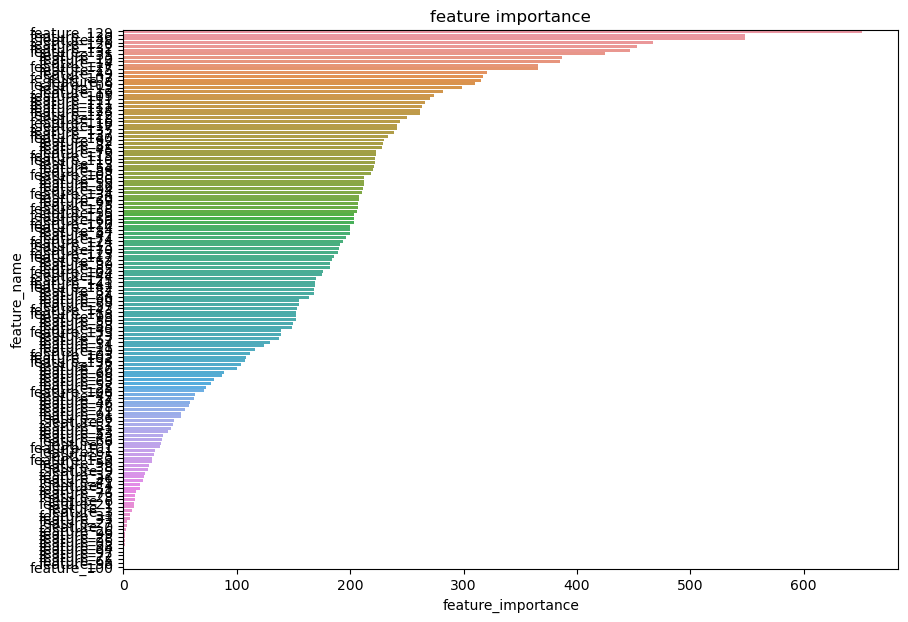

In [96]:
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

In [101]:
test.columns

Index(['rank', 'query_id', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7',
       ...
       'feature_134', 'feature_135', 'feature_136', 'feature_137',
       'feature_138', 'feature_139', 'feature_140', 'feature_141',
       'feature_142', 'feature_143'],
      dtype='object', length=146)

In [110]:
y_pred = model.predict(test[features])
ndcg_scores = []
for i in test_query.index:
    start = sum(test_query[:i])
    end = start + test_query[i]
    end = start + test_query[i]
    group_preds = y_pred[start:end]
    group_true = test[target_col].iloc[start:end]
    ndcg_scores.append(ndcg_at_k(group_true, 5))

average_ndcg_5 = np.mean(ndcg_scores)
print(f"Average NDCG@5: {average_ndcg_5}")

Average NDCG@5: 0.016095185557202744


# решение 3

In [111]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=42)
                           )
study.optimize(objective, n_trials=10)

[I 2024-04-29 23:46:41,427] A new study created in memory with name: no-name-c132b812-aba1-4511-81b4-8a2484172102
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.473162	valid_0's ndcg@3: 0.488408	valid_0's ndcg@5: 0.505774	valid_0's ndcg@10: 0.547863	valid_0's ndcg@20: 0.618362
[20]	valid_0's ndcg@1: 0.486627	valid_0's ndcg@3: 0.5055	valid_0's ndcg@5: 0.518108	valid_0's ndcg@10: 0.560423	valid_0's ndcg@20: 0.628358
[30]	valid_0's ndcg@1: 0.485518	valid_0's ndcg@3: 0.509006	valid_0's ndcg@5: 0.523757	valid_0's ndcg@10: 0.565037	valid_0's ndcg@20: 0.632432
[40]	valid_0's ndcg@1: 0.499513	valid_0's ndcg@3: 0.515961	valid_0's ndcg@5: 0.530979	valid_0's ndcg@10: 0.571257	valid_0's ndcg@20: 0.638695
[50]	valid_0's ndcg@1: 0.502025	valid_0's ndcg@3: 0.518965	valid_0's ndcg@5: 0.536084	valid_0's ndcg@10: 0.57457	valid_0's ndcg@20: 0.641458
[60]	valid_0's ndcg@1: 0.506902	valid_0's ndcg@3: 0.521558	valid_0's ndcg@5: 0.538654	valid_0's ndcg@10: 0.578747	valid_0's ndcg@20: 0.643461
[70]	valid_0's ndcg@1: 0.509266	valid_0's ndcg@3: 0.525173	valid_0's ndcg@5: 0.54249	valid

[I 2024-04-29 23:46:49,731] Trial 0 finished with value: 0.5744781768043928 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'max_depth': 7, 'num_leaves': 154, 'colsample_bytree': 0.24041677639819287, 'min_child_samples': 19}. Best is trial 0 with value: 0.5744781768043928.


Early stopping, best iteration is:
[235]	valid_0's ndcg@1: 0.52807	valid_0's ndcg@3: 0.538056	valid_0's ndcg@5: 0.555321	valid_0's ndcg@10: 0.593249	valid_0's ndcg@20: 0.657695


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.44398	valid_0's ndcg@3: 0.460777	valid_0's ndcg@5: 0.483653	valid_0's ndcg@10: 0.532047	valid_0's ndcg@20: 0.605778
[20]	valid_0's ndcg@1: 0.454917	valid_0's ndcg@3: 0.475853	valid_0's ndcg@5: 0.493902	valid_0's ndcg@10: 0.539597	valid_0's ndcg@20: 0.612467
[30]	valid_0's ndcg@1: 0.474729	valid_0's ndcg@3: 0.491256	valid_0's ndcg@5: 0.50865	valid_0's ndcg@10: 0.552069	valid_0's ndcg@20: 0.622697
[40]	valid_0's ndcg@1: 0.486841	valid_0's ndcg@3: 0.500208	valid_0's ndcg@5: 0.517225	valid_0's ndcg@10: 0.560176	valid_0's ndcg@20: 0.627808
[50]	valid_0's ndcg@1: 0.493218	valid_0's ndcg@3: 0.509174	valid_0's ndcg@5: 0.52504	valid_0's ndcg@10: 0.566919	valid_0's ndcg@20: 0.632504
[60]	valid_0's ndcg@1: 0.498257	valid_0's ndcg@3: 0.512476	valid_0's ndcg@5: 0.527502	valid_0's ndcg@10: 0.569585	valid_0's ndcg@20: 0.636072
[70]	valid_0's ndcg@1: 0.500602	valid_0's ndcg@3: 0.516671	valid_0's ndcg@5: 0.531544	vali

[I 2024-04-29 23:46:56,571] Trial 1 finished with value: 0.5692236627529382 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893, 'max_depth': 6, 'num_leaves': 182, 'colsample_bytree': 0.1185260448662222, 'min_child_samples': 98}. Best is trial 0 with value: 0.5744781768043928.


Early stopping, best iteration is:
[238]	valid_0's ndcg@1: 0.5207	valid_0's ndcg@3: 0.535427	valid_0's ndcg@5: 0.548492	valid_0's ndcg@10: 0.589265	valid_0's ndcg@20: 0.652234


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.458643	valid_0's ndcg@3: 0.474128	valid_0's ndcg@5: 0.49494	valid_0's ndcg@10: 0.538201	valid_0's ndcg@20: 0.607266
[20]	valid_0's ndcg@1: 0.467288	valid_0's ndcg@3: 0.486861	valid_0's ndcg@5: 0.503886	valid_0's ndcg@10: 0.546431	valid_0's ndcg@20: 0.615435
[30]	valid_0's ndcg@1: 0.477595	valid_0's ndcg@3: 0.495928	valid_0's ndcg@5: 0.512757	valid_0's ndcg@10: 0.553561	valid_0's ndcg@20: 0.621995
[40]	valid_0's ndcg@1: 0.490801	valid_0's ndcg@3: 0.503383	valid_0's ndcg@5: 0.520714	valid_0's ndcg@10: 0.561954	valid_0's ndcg@20: 0.628262
[50]	valid_0's ndcg@1: 0.49179	valid_0's ndcg@3: 0.509192	valid_0's ndcg@5: 0.523081	valid_0's ndcg@10: 0.564107	valid_0's ndcg@20: 0.631492
[60]	valid_0's ndcg@1: 0.497048	valid_0's ndcg@3: 0.512724	valid_0's ndcg@5: 0.527226	valid_0's ndcg@10: 0.56811	valid_0's ndcg@20: 0.634567
[70]	valid_0's ndcg@1: 0.502713	valid_0's ndcg@3: 0.514612	valid_0's ndcg@5: 0.530386	vali

[I 2024-04-29 23:47:03,351] Trial 2 finished with value: 0.5650483485595711 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07, 'max_depth': 4, 'num_leaves': 48, 'colsample_bytree': 0.373818018663584, 'min_child_samples': 55}. Best is trial 0 with value: 0.5744781768043928.


[320]	valid_0's ndcg@1: 0.519606	valid_0's ndcg@3: 0.528345	valid_0's ndcg@5: 0.54317	valid_0's ndcg@10: 0.582876	valid_0's ndcg@20: 0.647308
Early stopping, best iteration is:
[278]	valid_0's ndcg@1: 0.523084	valid_0's ndcg@3: 0.528271	valid_0's ndcg@5: 0.543839	valid_0's ndcg@10: 0.58261	valid_0's ndcg@20: 0.647438


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.473831	valid_0's ndcg@3: 0.486973	valid_0's ndcg@5: 0.502796	valid_0's ndcg@10: 0.546156	valid_0's ndcg@20: 0.616886
[20]	valid_0's ndcg@1: 0.489392	valid_0's ndcg@3: 0.503306	valid_0's ndcg@5: 0.518835	valid_0's ndcg@10: 0.560639	valid_0's ndcg@20: 0.629082
[30]	valid_0's ndcg@1: 0.49616	valid_0's ndcg@3: 0.508806	valid_0's ndcg@5: 0.524809	valid_0's ndcg@10: 0.566152	valid_0's ndcg@20: 0.632807
[40]	valid_0's ndcg@1: 0.502679	valid_0's ndcg@3: 0.512991	valid_0's ndcg@5: 0.528184	valid_0's ndcg@10: 0.570893	valid_0's ndcg@20: 0.636483
[50]	valid_0's ndcg@1: 0.510293	valid_0's ndcg@3: 0.518322	valid_0's ndcg@5: 0.535503	valid_0's ndcg@10: 0.574949	valid_0's ndcg@20: 0.640631
[60]	valid_0's ndcg@1: 0.514515	valid_0's ndcg@3: 0.523695	valid_0's ndcg@5: 0.539436	valid_0's ndcg@10: 0.578502	valid_0's ndcg@20: 0.643943
[70]	valid_0's ndcg@1: 0.518312	valid_0's ndcg@3: 0.524708	valid_0's ndcg@5: 0.539807	va

[I 2024-04-29 23:47:07,647] Trial 3 finished with value: 0.5643440457607923 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06, 'max_depth': 6, 'num_leaves': 37, 'colsample_bytree': 0.3629301836816964, 'min_child_samples': 40}. Best is trial 0 with value: 0.5744781768043928.


[130]	valid_0's ndcg@1: 0.516	valid_0's ndcg@3: 0.527396	valid_0's ndcg@5: 0.543241	valid_0's ndcg@10: 0.583438	valid_0's ndcg@20: 0.649418
Early stopping, best iteration is:
[87]	valid_0's ndcg@1: 0.521569	valid_0's ndcg@3: 0.527139	valid_0's ndcg@5: 0.543395	valid_0's ndcg@10: 0.581946	valid_0's ndcg@20: 0.647671


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.460367	valid_0's ndcg@3: 0.47391	valid_0's ndcg@5: 0.492797	valid_0's ndcg@10: 0.536906	valid_0's ndcg@20: 0.607137
[20]	valid_0's ndcg@1: 0.475168	valid_0's ndcg@3: 0.488413	valid_0's ndcg@5: 0.506799	valid_0's ndcg@10: 0.5491	valid_0's ndcg@20: 0.618102
[30]	valid_0's ndcg@1: 0.48261	valid_0's ndcg@3: 0.49771	valid_0's ndcg@5: 0.513818	valid_0's ndcg@10: 0.556033	valid_0's ndcg@20: 0.624893
[40]	valid_0's ndcg@1: 0.492134	valid_0's ndcg@3: 0.502939	valid_0's ndcg@5: 0.51987	valid_0's ndcg@10: 0.562222	valid_0's ndcg@20: 0.629504
[50]	valid_0's ndcg@1: 0.497278	valid_0's ndcg@3: 0.508703	valid_0's ndcg@5: 0.524006	valid_0's ndcg@10: 0.564641	valid_0's ndcg@20: 0.631854
[60]	valid_0's ndcg@1: 0.504136	valid_0's ndcg@3: 0.513843	valid_0's ndcg@5: 0.528621	valid_0's ndcg@10: 0.569709	valid_0's ndcg@20: 0.635749
[70]	valid_0's ndcg@1: 0.508698	valid_0's ndcg@3: 0.51407	valid_0's ndcg@5: 0.532691	valid_0'

[I 2024-04-29 23:47:12,833] Trial 4 finished with value: 0.5610399248133902 and parameters: {'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'max_depth': 4, 'num_leaves': 133, 'colsample_bytree': 0.6331731119758383, 'min_child_samples': 9}. Best is trial 0 with value: 0.5744781768043928.


Early stopping, best iteration is:
[157]	valid_0's ndcg@1: 0.518078	valid_0's ndcg@3: 0.524419	valid_0's ndcg@5: 0.539879	valid_0's ndcg@10: 0.578777	valid_0's ndcg@20: 0.644047


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.455486	valid_0's ndcg@3: 0.463729	valid_0's ndcg@5: 0.480383	valid_0's ndcg@10: 0.524031	valid_0's ndcg@20: 0.597753
[20]	valid_0's ndcg@1: 0.465339	valid_0's ndcg@3: 0.478339	valid_0's ndcg@5: 0.496738	valid_0's ndcg@10: 0.54039	valid_0's ndcg@20: 0.610955
[30]	valid_0's ndcg@1: 0.476539	valid_0's ndcg@3: 0.487446	valid_0's ndcg@5: 0.50572	valid_0's ndcg@10: 0.548625	valid_0's ndcg@20: 0.618816
[40]	valid_0's ndcg@1: 0.476873	valid_0's ndcg@3: 0.490372	valid_0's ndcg@5: 0.510255	valid_0's ndcg@10: 0.552378	valid_0's ndcg@20: 0.622478
[50]	valid_0's ndcg@1: 0.480097	valid_0's ndcg@3: 0.495295	valid_0's ndcg@5: 0.515124	valid_0's ndcg@10: 0.55681	valid_0's ndcg@20: 0.626346
[60]	valid_0's ndcg@1: 0.487749	valid_0's ndcg@3: 0.500402	valid_0's ndcg@5: 0.520039	valid_0's ndcg@10: 0.55993	valid_0's ndcg@20: 0.629586
[70]	valid_0's ndcg@1: 0.491603	valid_0's ndcg@3: 0.505236	valid_0's ndcg@5: 0.521903	valid

[I 2024-04-29 23:47:20,493] Trial 5 finished with value: 0.5585850105195174 and parameters: {'lambda_l1': 0.0029369981104377003, 'lambda_l2': 3.425445902633376e-07, 'max_depth': 3, 'num_leaves': 243, 'colsample_bytree': 0.9690688297671034, 'min_child_samples': 82}. Best is trial 0 with value: 0.5744781768043928.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Us

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.46253	valid_0's ndcg@3: 0.480202	valid_0's ndcg@5: 0.499106	valid_0's ndcg@10: 0.544538	valid_0's ndcg@20: 0.614818
[20]	valid_0's ndcg@1: 0.474318	valid_0's ndcg@3: 0.491894	valid_0's ndcg@5: 0.512265	valid_0's ndcg@10: 0.557044	valid_0's ndcg@20: 0.624915
[30]	valid_0's ndcg@1: 0.486612	valid_0's ndcg@3: 0.506485	valid_0's ndcg@5: 0.520906	valid_0's ndcg@10: 0.564616	valid_0's ndcg@20: 0.631198
[40]	valid_0's ndcg@1: 0.494512	valid_0's ndcg@3: 0.513189	valid_0's ndcg@5: 0.527955	valid_0's ndcg@10: 0.569837	valid_0's ndcg@20: 0.637144
[50]	valid_0's ndcg@1: 0.501533	valid_0's ndcg@3: 0.513511	valid_0's ndcg@5: 0.530853	valid_0's ndcg@10: 0.572387	valid_0's ndcg@20: 0.639519
[60]	valid_0's ndcg@1: 0.512318	valid_0's ndcg@3: 0.519147	valid_0's ndcg@5: 0.536376	valid_0's ndcg@10: 0.577699	valid_0's ndcg@20: 0.643439
[70]	valid_0's ndcg@1: 0.513679	valid_0's ndcg@3: 0.523097	valid_0's ndcg@5: 0.540064	va

[I 2024-04-29 23:47:27,529] Trial 6 finished with value: 0.5745330918339022 and parameters: {'lambda_l1': 5.514725787121931e-06, 'lambda_l2': 7.569183361880229e-08, 'max_depth': 7, 'num_leaves': 114, 'colsample_bytree': 0.20983441136030095, 'min_child_samples': 52}. Best is trial 6 with value: 0.5745330918339022.
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\U

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.466366	valid_0's ndcg@3: 0.478214	valid_0's ndcg@5: 0.496053	valid_0's ndcg@10: 0.537591	valid_0's ndcg@20: 0.60762
[20]	valid_0's ndcg@1: 0.477547	valid_0's ndcg@3: 0.492069	valid_0's ndcg@5: 0.508067	valid_0's ndcg@10: 0.547679	valid_0's ndcg@20: 0.619065
[30]	valid_0's ndcg@1: 0.478961	valid_0's ndcg@3: 0.497714	valid_0's ndcg@5: 0.514083	valid_0's ndcg@10: 0.554758	valid_0's ndcg@20: 0.623403
[40]	valid_0's ndcg@1: 0.491331	valid_0's ndcg@3: 0.505468	valid_0's ndcg@5: 0.521057	valid_0's ndcg@10: 0.56084	valid_0's ndcg@20: 0.629169
[50]	valid_0's ndcg@1: 0.494565	valid_0's ndcg@3: 0.507254	valid_0's ndcg@5: 0.52388	valid_0's ndcg@10: 0.563917	valid_0's ndcg@20: 0.631188
[60]	valid_0's ndcg@1: 0.502517	valid_0's ndcg@3: 0.512078	valid_0's ndcg@5: 0.525906	valid_0's ndcg@10: 0.568336	valid_0's ndcg@20: 0.634559
[70]	valid_0's ndcg@1: 0.508272	valid_0's ndcg@3: 0.515239	valid_0's ndcg@5: 0.529803	vali

[I 2024-04-29 23:47:31,705] Trial 7 finished with value: 0.5602085548079871 and parameters: {'lambda_l1': 2.039373116525212e-08, 'lambda_l2': 1.527156759251193, 'max_depth': 4, 'num_leaves': 170, 'colsample_bytree': 0.3805399684804699, 'min_child_samples': 54}. Best is trial 6 with value: 0.5745330918339022.


[160]	valid_0's ndcg@1: 0.513794	valid_0's ndcg@3: 0.52395	valid_0's ndcg@5: 0.539509	valid_0's ndcg@10: 0.578285	valid_0's ndcg@20: 0.644539
[170]	valid_0's ndcg@1: 0.513092	valid_0's ndcg@3: 0.524743	valid_0's ndcg@5: 0.54071	valid_0's ndcg@10: 0.578785	valid_0's ndcg@20: 0.644712
Early stopping, best iteration is:
[122]	valid_0's ndcg@1: 0.519344	valid_0's ndcg@3: 0.522783	valid_0's ndcg@5: 0.537705	valid_0's ndcg@10: 0.577393	valid_0's ndcg@20: 0.643818


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.484812	valid_0's ndcg@3: 0.494141	valid_0's ndcg@5: 0.50908	valid_0's ndcg@10: 0.552934	valid_0's ndcg@20: 0.621472
[20]	valid_0's ndcg@1: 0.491169	valid_0's ndcg@3: 0.501495	valid_0's ndcg@5: 0.521246	valid_0's ndcg@10: 0.563511	valid_0's ndcg@20: 0.630344
[30]	valid_0's ndcg@1: 0.501619	valid_0's ndcg@3: 0.515201	valid_0's ndcg@5: 0.535024	valid_0's ndcg@10: 0.572082	valid_0's ndcg@20: 0.640088
[40]	valid_0's ndcg@1: 0.513607	valid_0's ndcg@3: 0.521662	valid_0's ndcg@5: 0.539997	valid_0's ndcg@10: 0.580128	valid_0's ndcg@20: 0.645752
[50]	valid_0's ndcg@1: 0.519329	valid_0's ndcg@3: 0.524292	valid_0's ndcg@5: 0.544505	valid_0's ndcg@10: 0.583523	valid_0's ndcg@20: 0.648674
[60]	valid_0's ndcg@1: 0.512953	valid_0's ndcg@3: 0.527656	valid_0's ndcg@5: 0.546079	valid_0's ndcg@10: 0.584676	valid_0's ndcg@20: 0.650118
[70]	valid_0's ndcg@1: 0.515193	valid_0's ndcg@3: 0.528163	valid_0's ndcg@5: 0.546485	va

[I 2024-04-29 23:47:36,879] Trial 8 finished with value: 0.5646604698259073 and parameters: {'lambda_l1': 0.0008325158565947976, 'lambda_l2': 4.609885087947832e-07, 'max_depth': 8, 'num_leaves': 199, 'colsample_bytree': 0.9455490474077702, 'min_child_samples': 90}. Best is trial 6 with value: 0.5745330918339022.


[100]	valid_0's ndcg@1: 0.519735	valid_0's ndcg@3: 0.532955	valid_0's ndcg@5: 0.550433	valid_0's ndcg@10: 0.58924	valid_0's ndcg@20: 0.655003
Early stopping, best iteration is:
[51]	valid_0's ndcg@1: 0.520891	valid_0's ndcg@3: 0.524937	valid_0's ndcg@5: 0.54481	valid_0's ndcg@10: 0.583833	valid_0's ndcg@20: 0.648831


C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\savolk25\AppData\Local\Temp\ipykernel_19764\389573219.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree',

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.417008	valid_0's ndcg@3: 0.436942	valid_0's ndcg@5: 0.457679	valid_0's ndcg@10: 0.509315	valid_0's ndcg@20: 0.58505
[20]	valid_0's ndcg@1: 0.446669	valid_0's ndcg@3: 0.464334	valid_0's ndcg@5: 0.481721	valid_0's ndcg@10: 0.528879	valid_0's ndcg@20: 0.600831
[30]	valid_0's ndcg@1: 0.462029	valid_0's ndcg@3: 0.469706	valid_0's ndcg@5: 0.48764	valid_0's ndcg@10: 0.533148	valid_0's ndcg@20: 0.606291
[40]	valid_0's ndcg@1: 0.469341	valid_0's ndcg@3: 0.476425	valid_0's ndcg@5: 0.494483	valid_0's ndcg@10: 0.538913	valid_0's ndcg@20: 0.611158
[50]	valid_0's ndcg@1: 0.472866	valid_0's ndcg@3: 0.482434	valid_0's ndcg@5: 0.499801	valid_0's ndcg@10: 0.543301	valid_0's ndcg@20: 0.614991
[60]	valid_0's ndcg@1: 0.484721	valid_0's ndcg@3: 0.493015	valid_0's ndcg@5: 0.507859	valid_0's ndcg@10: 0.548606	valid_0's ndcg@20: 0.619707
[70]	valid_0's ndcg@1: 0.486708	valid_0's ndcg@3: 0.497901	valid_0's ndcg@5: 0.51196	vali

[I 2024-04-29 23:47:41,687] Trial 9 finished with value: 0.5482840494455463 and parameters: {'lambda_l1': 0.002404915432737351, 'lambda_l2': 1.9809253750493907, 'max_depth': 3, 'num_leaves': 51, 'colsample_bytree': 0.14070456001948428, 'min_child_samples': 36}. Best is trial 6 with value: 0.5745330918339022.


[200]	valid_0's ndcg@1: 0.498281	valid_0's ndcg@3: 0.51186	valid_0's ndcg@5: 0.529401	valid_0's ndcg@10: 0.56673	valid_0's ndcg@20: 0.635714
Early stopping, best iteration is:
[154]	valid_0's ndcg@1: 0.501337	valid_0's ndcg@3: 0.511967	valid_0's ndcg@5: 0.528752	valid_0's ndcg@10: 0.565128	valid_0's ndcg@20: 0.634236


In [112]:
best_params = study.best_trial.params
model = lgb.LGBMRanker(n_estimators=1000, **best_params, random_state=42,)
model.fit(
    train[features],
    train[target_col],
    group=train_query,
    eval_set=[(test[features], test[target_col])],
    eval_group=[list(test_query)],
    eval_at=[1, 3, 5, 10, 20],
    early_stopping_rounds=50,
    verbose=10
)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.46253	valid_0's ndcg@3: 0.480202	valid_0's ndcg@5: 0.499106	valid_0's ndcg@10: 0.544538	valid_0's ndcg@20: 0.614818
[20]	valid_0's ndcg@1: 0.474318	valid_0's ndcg@3: 0.491894	valid_0's ndcg@5: 0.512265	valid_0's ndcg@10: 0.557044	valid_0's ndcg@20: 0.624915
[30]	valid_0's ndcg@1: 0.486612	valid_0's ndcg@3: 0.506485	valid_0's ndcg@5: 0.520906	valid_0's ndcg@10: 0.564616	valid_0's ndcg@20: 0.631198
[40]	valid_0's ndcg@1: 0.494512	valid_0's ndcg@3: 0.513189	valid_0's ndcg@5: 0.527955	valid_0's ndcg@10: 0.569837	valid_0's ndcg@20: 0.637144
[50]	valid_0's ndcg@1: 0.501533	valid_0's ndcg@3: 0.513511	valid_0's ndcg@5: 0.530853	valid_0's ndcg@10: 0.572387	valid_0's ndcg@20: 0.639519
[60]	valid_0's ndcg@1: 0.512318	valid_0's ndcg@3: 0.519147	valid_0's ndcg@5: 0.536376	valid_0's ndcg@10: 0.577699	valid_0's ndcg@20: 0.643439
[70]	valid_0's ndcg@1: 0.513679	valid_0's ndcg@3: 0.523097	valid_0's ndcg@5: 0.540064	va

LGBMRanker(colsample_bytree=0.20983441136030095,
           lambda_l1=5.514725787121931e-06, lambda_l2=7.569183361880229e-08,
           max_depth=7, min_child_samples=52, n_estimators=1000, num_leaves=114,
           random_state=42)

In [113]:
y_pred = model.predict(test[features])
ndcg_scores = []
for i in test_query.index:
    start = sum(test_query[:i])
    end = start + test_query[i]
    end = start + test_query[i]
    group_preds = y_pred[start:end]
    group_true = test[target_col].iloc[start:end]
    ndcg_scores.append(ndcg_at_k(group_true, 5))

average_ndcg_5 = np.mean(ndcg_scores)
print(f"Average NDCG@5: {average_ndcg_5}")

Average NDCG@5: 0.016095185557202744
